# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.37KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

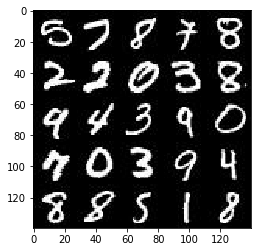

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

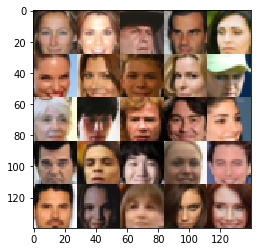

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_real")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="inputs_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    return input_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same', use_bias=False)
        bn1 = tf.layers.batch_normalization(x1, training=True)        
        relu1 = tf.maximum(alpha * bn1, bn1)

        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same', use_bias=False)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same', use_bias=False)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        x4 = tf.layers.conv2d(relu2, 1024, 5, strides=2, padding='same', use_bias=False)
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        
        flat = tf.reshape(relu4, (-1,4*4*512))
        
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    #alpha = 0.2
    # TODO: Implement Function
    #if is_train == True:
    with tf.variable_scope('generator', reuse=not is_train):
            
        x1 = tf.layers.dense(z, 7*7*512, activation = None)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        #x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.nn.relu(x1)
            
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', use_bias=False)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.nn.relu(x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', use_bias=False)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.nn.relu(x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 2, strides=2, padding='same')
        logits = tf.image.resize_images(logits, (28,28))
        out = tf.tanh(logits)

    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                         labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                    labels=tf.ones_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #saver = tf.train.Saver()
    
    losses = []
    
    steps = 0
    print_every = 10
    show_every = 100
    im_width = data_shape[1]
    im_height = data_shape[2]
    im_filters = data_shape[3]
    out_dim = data_shape[3]
    
    input_real, input_z, lr = model_inputs(im_width, im_height, im_filters, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, out_dim)
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images * 2
                #print(batch_images.shape)
                #print(batch_images.dtype)
                steps += 1
                #batch_images_1 = get_batches(batch_size)[batch_images*batch_size]
                #create the 'white noise' input as a matrix of random values from -1 to 1
                batch_z = np.random.uniform(-1,1, size=(batch_size, z_dim)) 
                
                #run the optimizers
                #first the discriminator
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: batch_z, 
                                                     lr: learning_rate})
                
                #then the generator
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images,
                                                     input_z: batch_z, 
                                                     lr: learning_rate})
                
                if steps % print_every == 0:
                    #get the losses
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real:batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    #save the losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                if steps % show_every == 0:
                    
                    show_generator_output(sess, 15, input_z, out_dim, data_image_mode)

    #with open('samples.pk1', 'wb') as f:
    #    pkl.dump(samples, f)
        
    return losses
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/3... Discriminator Loss: 0.0153... Generator Loss: 11.2022
Epoch 1/3... Discriminator Loss: 0.0189... Generator Loss: 15.6368
Epoch 1/3... Discriminator Loss: 1.1474... Generator Loss: 13.6239
Epoch 1/3... Discriminator Loss: 0.1221... Generator Loss: 17.4283
Epoch 1/3... Discriminator Loss: 0.1468... Generator Loss: 11.8032
Epoch 1/3... Discriminator Loss: 0.5292... Generator Loss: 17.5272
Epoch 1/3... Discriminator Loss: 1.6793... Generator Loss: 1.2145
Epoch 1/3... Discriminator Loss: 0.8553... Generator Loss: 2.7744
Epoch 1/3... Discriminator Loss: 0.5237... Generator Loss: 2.1532
Epoch 1/3... Discriminator Loss: 2.6805... Generator Loss: 5.3765


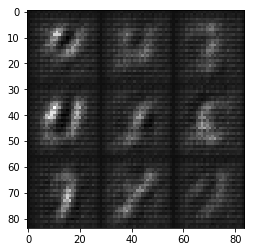

Epoch 1/3... Discriminator Loss: 0.6369... Generator Loss: 1.6268
Epoch 1/3... Discriminator Loss: 1.6575... Generator Loss: 0.4499
Epoch 1/3... Discriminator Loss: 1.1910... Generator Loss: 3.0043
Epoch 1/3... Discriminator Loss: 1.3398... Generator Loss: 2.6294
Epoch 1/3... Discriminator Loss: 0.9409... Generator Loss: 0.9565
Epoch 1/3... Discriminator Loss: 0.8720... Generator Loss: 1.3940
Epoch 1/3... Discriminator Loss: 0.8462... Generator Loss: 0.9300
Epoch 1/3... Discriminator Loss: 0.6736... Generator Loss: 1.2299
Epoch 1/3... Discriminator Loss: 0.6552... Generator Loss: 1.5767
Epoch 1/3... Discriminator Loss: 1.1236... Generator Loss: 2.5798


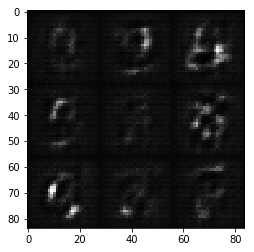

Epoch 1/3... Discriminator Loss: 0.7936... Generator Loss: 1.3522
Epoch 1/3... Discriminator Loss: 1.6434... Generator Loss: 4.0957
Epoch 1/3... Discriminator Loss: 0.7547... Generator Loss: 1.0472
Epoch 1/3... Discriminator Loss: 0.6713... Generator Loss: 1.4468
Epoch 1/3... Discriminator Loss: 0.6432... Generator Loss: 1.1824
Epoch 1/3... Discriminator Loss: 0.6522... Generator Loss: 2.0778
Epoch 1/3... Discriminator Loss: 1.2022... Generator Loss: 0.5041
Epoch 1/3... Discriminator Loss: 0.8291... Generator Loss: 2.6197
Epoch 1/3... Discriminator Loss: 0.9457... Generator Loss: 0.7334
Epoch 1/3... Discriminator Loss: 0.6615... Generator Loss: 1.3947


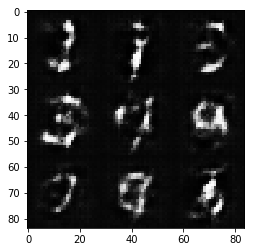

Epoch 1/3... Discriminator Loss: 0.6369... Generator Loss: 1.4027
Epoch 1/3... Discriminator Loss: 0.9154... Generator Loss: 2.8521
Epoch 1/3... Discriminator Loss: 1.0551... Generator Loss: 0.5565
Epoch 1/3... Discriminator Loss: 0.7809... Generator Loss: 2.3640
Epoch 1/3... Discriminator Loss: 0.8311... Generator Loss: 0.9879
Epoch 1/3... Discriminator Loss: 0.7459... Generator Loss: 1.4398
Epoch 1/3... Discriminator Loss: 0.6875... Generator Loss: 1.1279
Epoch 1/3... Discriminator Loss: 1.5102... Generator Loss: 3.8227
Epoch 1/3... Discriminator Loss: 1.0246... Generator Loss: 2.0171
Epoch 1/3... Discriminator Loss: 0.6315... Generator Loss: 1.7967


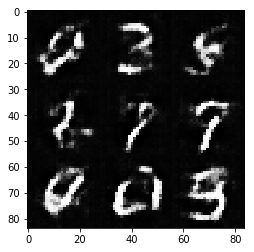

Epoch 1/3... Discriminator Loss: 0.9549... Generator Loss: 1.9608
Epoch 1/3... Discriminator Loss: 0.7101... Generator Loss: 0.9323
Epoch 1/3... Discriminator Loss: 0.8289... Generator Loss: 1.3967
Epoch 1/3... Discriminator Loss: 1.1426... Generator Loss: 2.7036
Epoch 1/3... Discriminator Loss: 1.1051... Generator Loss: 0.7199
Epoch 1/3... Discriminator Loss: 0.7649... Generator Loss: 0.9245
Epoch 2/3... Discriminator Loss: 0.8111... Generator Loss: 1.8122
Epoch 2/3... Discriminator Loss: 0.7976... Generator Loss: 1.5934
Epoch 2/3... Discriminator Loss: 0.7012... Generator Loss: 1.2207
Epoch 2/3... Discriminator Loss: 0.7220... Generator Loss: 1.1648


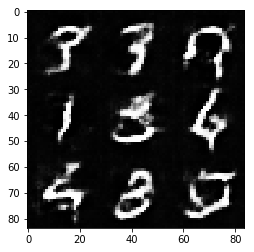

Epoch 2/3... Discriminator Loss: 0.8287... Generator Loss: 1.8822
Epoch 2/3... Discriminator Loss: 1.0872... Generator Loss: 0.5512
Epoch 2/3... Discriminator Loss: 0.8130... Generator Loss: 2.4749
Epoch 2/3... Discriminator Loss: 0.8310... Generator Loss: 0.9308
Epoch 2/3... Discriminator Loss: 1.5663... Generator Loss: 0.3689
Epoch 2/3... Discriminator Loss: 0.7214... Generator Loss: 1.3841
Epoch 2/3... Discriminator Loss: 0.9946... Generator Loss: 0.7804
Epoch 2/3... Discriminator Loss: 0.8164... Generator Loss: 2.0357
Epoch 2/3... Discriminator Loss: 0.9758... Generator Loss: 0.6575
Epoch 2/3... Discriminator Loss: 0.6419... Generator Loss: 2.1936


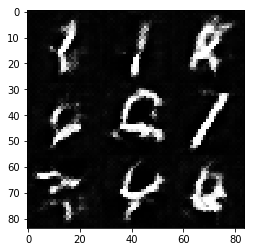

Epoch 2/3... Discriminator Loss: 0.9779... Generator Loss: 0.6453
Epoch 2/3... Discriminator Loss: 0.7116... Generator Loss: 1.5158
Epoch 2/3... Discriminator Loss: 0.7415... Generator Loss: 1.0419
Epoch 2/3... Discriminator Loss: 0.7701... Generator Loss: 0.9454
Epoch 2/3... Discriminator Loss: 0.6542... Generator Loss: 1.2346
Epoch 2/3... Discriminator Loss: 0.5848... Generator Loss: 1.7530
Epoch 2/3... Discriminator Loss: 0.9215... Generator Loss: 1.8811
Epoch 2/3... Discriminator Loss: 1.2641... Generator Loss: 1.6810
Epoch 2/3... Discriminator Loss: 2.2546... Generator Loss: 0.1522
Epoch 2/3... Discriminator Loss: 0.7167... Generator Loss: 1.3000


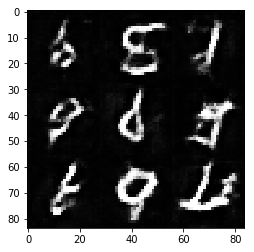

Epoch 2/3... Discriminator Loss: 0.9831... Generator Loss: 0.7194
Epoch 2/3... Discriminator Loss: 0.9062... Generator Loss: 0.8271
Epoch 2/3... Discriminator Loss: 0.8917... Generator Loss: 0.8986
Epoch 2/3... Discriminator Loss: 2.2428... Generator Loss: 0.1651
Epoch 2/3... Discriminator Loss: 1.0412... Generator Loss: 1.3012
Epoch 2/3... Discriminator Loss: 0.8589... Generator Loss: 0.9214
Epoch 2/3... Discriminator Loss: 0.9022... Generator Loss: 1.1374
Epoch 2/3... Discriminator Loss: 0.8610... Generator Loss: 0.9964
Epoch 2/3... Discriminator Loss: 0.9057... Generator Loss: 2.2420
Epoch 2/3... Discriminator Loss: 0.8928... Generator Loss: 0.8278


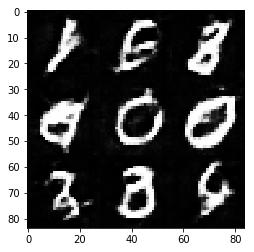

Epoch 2/3... Discriminator Loss: 1.0765... Generator Loss: 2.1041
Epoch 2/3... Discriminator Loss: 0.8264... Generator Loss: 1.6444
Epoch 2/3... Discriminator Loss: 1.0454... Generator Loss: 0.6810
Epoch 2/3... Discriminator Loss: 1.3838... Generator Loss: 1.8614
Epoch 2/3... Discriminator Loss: 1.1305... Generator Loss: 0.9381
Epoch 2/3... Discriminator Loss: 0.8892... Generator Loss: 1.1129
Epoch 2/3... Discriminator Loss: 1.1151... Generator Loss: 2.1408
Epoch 2/3... Discriminator Loss: 1.2236... Generator Loss: 0.5625
Epoch 2/3... Discriminator Loss: 0.9094... Generator Loss: 1.8760
Epoch 2/3... Discriminator Loss: 0.6750... Generator Loss: 1.4952


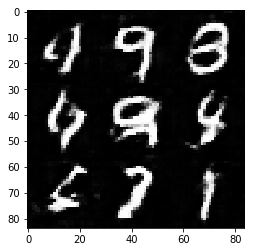

Epoch 2/3... Discriminator Loss: 1.4123... Generator Loss: 1.9279
Epoch 2/3... Discriminator Loss: 1.2677... Generator Loss: 1.0150
Epoch 2/3... Discriminator Loss: 0.9974... Generator Loss: 0.7766
Epoch 3/3... Discriminator Loss: 0.9849... Generator Loss: 1.1814
Epoch 3/3... Discriminator Loss: 0.9087... Generator Loss: 1.2039
Epoch 3/3... Discriminator Loss: 0.7928... Generator Loss: 1.1374
Epoch 3/3... Discriminator Loss: 1.0882... Generator Loss: 0.6217
Epoch 3/3... Discriminator Loss: 0.8384... Generator Loss: 1.1236
Epoch 3/3... Discriminator Loss: 0.8362... Generator Loss: 0.8995
Epoch 3/3... Discriminator Loss: 0.8434... Generator Loss: 1.5093


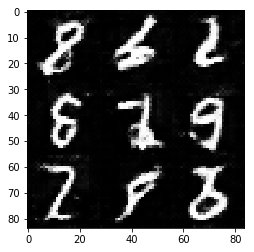

Epoch 3/3... Discriminator Loss: 0.7954... Generator Loss: 1.1931
Epoch 3/3... Discriminator Loss: 1.2460... Generator Loss: 0.5727
Epoch 3/3... Discriminator Loss: 0.6541... Generator Loss: 1.7490
Epoch 3/3... Discriminator Loss: 1.4173... Generator Loss: 0.3651
Epoch 3/3... Discriminator Loss: 0.9680... Generator Loss: 1.1253
Epoch 3/3... Discriminator Loss: 0.8582... Generator Loss: 1.0851
Epoch 3/3... Discriminator Loss: 0.8712... Generator Loss: 1.8459
Epoch 3/3... Discriminator Loss: 1.2557... Generator Loss: 0.5625
Epoch 3/3... Discriminator Loss: 0.6297... Generator Loss: 2.0121
Epoch 3/3... Discriminator Loss: 1.2736... Generator Loss: 1.4477


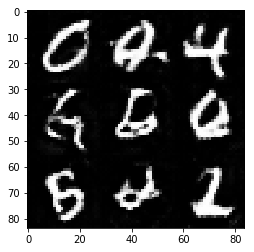

Epoch 3/3... Discriminator Loss: 0.8135... Generator Loss: 1.3830
Epoch 3/3... Discriminator Loss: 1.3751... Generator Loss: 0.3990
Epoch 3/3... Discriminator Loss: 1.2591... Generator Loss: 0.4795
Epoch 3/3... Discriminator Loss: 0.5922... Generator Loss: 1.3002
Epoch 3/3... Discriminator Loss: 0.8407... Generator Loss: 0.9427
Epoch 3/3... Discriminator Loss: 1.1178... Generator Loss: 1.6376
Epoch 3/3... Discriminator Loss: 1.4281... Generator Loss: 0.3991
Epoch 3/3... Discriminator Loss: 0.7340... Generator Loss: 1.1224
Epoch 3/3... Discriminator Loss: 1.4275... Generator Loss: 0.4066
Epoch 3/3... Discriminator Loss: 0.8653... Generator Loss: 1.2086


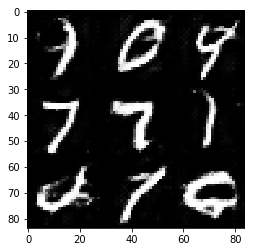

Epoch 3/3... Discriminator Loss: 0.9855... Generator Loss: 0.6958
Epoch 3/3... Discriminator Loss: 0.9863... Generator Loss: 1.0703
Epoch 3/3... Discriminator Loss: 0.8708... Generator Loss: 1.2476
Epoch 3/3... Discriminator Loss: 0.9819... Generator Loss: 0.9320
Epoch 3/3... Discriminator Loss: 1.4932... Generator Loss: 0.4270
Epoch 3/3... Discriminator Loss: 0.9481... Generator Loss: 0.8372
Epoch 3/3... Discriminator Loss: 0.8517... Generator Loss: 1.3168
Epoch 3/3... Discriminator Loss: 0.8670... Generator Loss: 0.9556
Epoch 3/3... Discriminator Loss: 0.8351... Generator Loss: 1.1545
Epoch 3/3... Discriminator Loss: 1.1215... Generator Loss: 0.5949


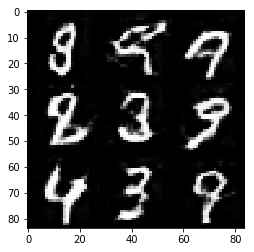

Epoch 3/3... Discriminator Loss: 0.8093... Generator Loss: 0.7985
Epoch 3/3... Discriminator Loss: 0.7980... Generator Loss: 1.3027
Epoch 3/3... Discriminator Loss: 0.8789... Generator Loss: 0.9309
Epoch 3/3... Discriminator Loss: 1.0243... Generator Loss: 0.7144
Epoch 3/3... Discriminator Loss: 1.8826... Generator Loss: 0.2814
Epoch 3/3... Discriminator Loss: 1.2461... Generator Loss: 2.6229
Epoch 3/3... Discriminator Loss: 0.9614... Generator Loss: 0.6882
Epoch 3/3... Discriminator Loss: 0.9571... Generator Loss: 2.4577
Epoch 3/3... Discriminator Loss: 0.6590... Generator Loss: 2.3017
Epoch 3/3... Discriminator Loss: 0.6579... Generator Loss: 1.7848


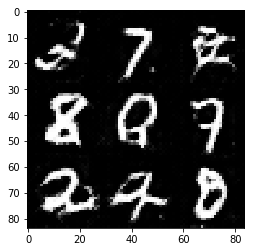

In [18]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

In [78]:
print(mnist_dataset.shape)

(60000, 28, 28, 1)


### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/10... Discriminator Loss: 0.1203... Generator Loss: 8.7303
Epoch 1/10... Discriminator Loss: 0.1857... Generator Loss: 4.0253
Epoch 1/10... Discriminator Loss: 0.0983... Generator Loss: 34.5964
Epoch 1/10... Discriminator Loss: 0.0383... Generator Loss: 28.2315
Epoch 1/10... Discriminator Loss: 0.0394... Generator Loss: 34.8010
Epoch 1/10... Discriminator Loss: 8.6310... Generator Loss: 0.0010
Epoch 1/10... Discriminator Loss: 0.0350... Generator Loss: 14.5511
Epoch 1/10... Discriminator Loss: 0.1780... Generator Loss: 7.5487
Epoch 1/10... Discriminator Loss: 1.9560... Generator Loss: 2.2929
Epoch 1/10... Discriminator Loss: 1.6161... Generator Loss: 0.4454


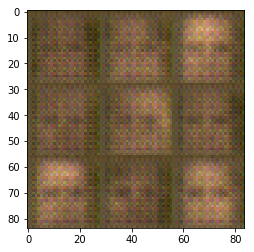

Epoch 1/10... Discriminator Loss: 1.6817... Generator Loss: 0.4700
Epoch 1/10... Discriminator Loss: 1.4456... Generator Loss: 1.3059
Epoch 1/10... Discriminator Loss: 1.1707... Generator Loss: 0.9955
Epoch 1/10... Discriminator Loss: 1.3053... Generator Loss: 1.8153
Epoch 1/10... Discriminator Loss: 1.1132... Generator Loss: 0.7132
Epoch 1/10... Discriminator Loss: 1.1352... Generator Loss: 1.3885
Epoch 1/10... Discriminator Loss: 1.1480... Generator Loss: 0.7654
Epoch 1/10... Discriminator Loss: 1.4320... Generator Loss: 1.0177
Epoch 1/10... Discriminator Loss: 1.3450... Generator Loss: 0.7407
Epoch 1/10... Discriminator Loss: 0.8414... Generator Loss: 1.9822


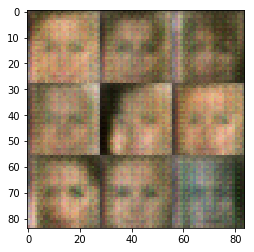

Epoch 1/10... Discriminator Loss: 1.0278... Generator Loss: 1.1989
Epoch 1/10... Discriminator Loss: 1.0746... Generator Loss: 1.7098
Epoch 1/10... Discriminator Loss: 1.2557... Generator Loss: 0.8391
Epoch 1/10... Discriminator Loss: 1.1349... Generator Loss: 1.1304
Epoch 1/10... Discriminator Loss: 1.0258... Generator Loss: 1.5352
Epoch 1/10... Discriminator Loss: 0.9831... Generator Loss: 0.9134
Epoch 1/10... Discriminator Loss: 1.1875... Generator Loss: 0.5950
Epoch 1/10... Discriminator Loss: 1.2463... Generator Loss: 2.3079
Epoch 1/10... Discriminator Loss: 1.1474... Generator Loss: 0.5961
Epoch 1/10... Discriminator Loss: 1.4098... Generator Loss: 0.5255


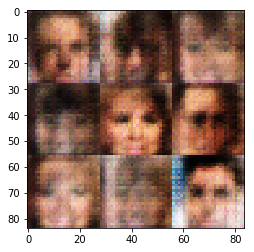

Epoch 1/10... Discriminator Loss: 0.9782... Generator Loss: 1.9295
Epoch 1/10... Discriminator Loss: 1.1543... Generator Loss: 0.6092
Epoch 1/10... Discriminator Loss: 1.3805... Generator Loss: 0.5191
Epoch 1/10... Discriminator Loss: 1.9790... Generator Loss: 2.8767
Epoch 1/10... Discriminator Loss: 1.4970... Generator Loss: 0.4394
Epoch 1/10... Discriminator Loss: 1.2411... Generator Loss: 0.6101
Epoch 1/10... Discriminator Loss: 1.4819... Generator Loss: 1.1250
Epoch 1/10... Discriminator Loss: 1.4200... Generator Loss: 0.5554
Epoch 1/10... Discriminator Loss: 1.2284... Generator Loss: 1.2869
Epoch 1/10... Discriminator Loss: 1.4354... Generator Loss: 0.8260


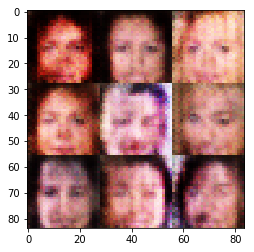

Epoch 1/10... Discriminator Loss: 1.3874... Generator Loss: 1.1629
Epoch 1/10... Discriminator Loss: 1.2135... Generator Loss: 0.7702
Epoch 1/10... Discriminator Loss: 1.4860... Generator Loss: 0.5236
Epoch 1/10... Discriminator Loss: 1.2100... Generator Loss: 0.7329
Epoch 1/10... Discriminator Loss: 1.1715... Generator Loss: 0.7126
Epoch 1/10... Discriminator Loss: 1.2568... Generator Loss: 1.2166
Epoch 1/10... Discriminator Loss: 1.1945... Generator Loss: 1.1760
Epoch 1/10... Discriminator Loss: 1.1728... Generator Loss: 0.6904
Epoch 1/10... Discriminator Loss: 1.3161... Generator Loss: 0.5734
Epoch 1/10... Discriminator Loss: 1.2279... Generator Loss: 0.6977


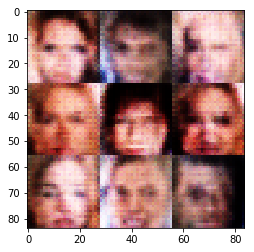

Epoch 1/10... Discriminator Loss: 1.3726... Generator Loss: 1.1664
Epoch 1/10... Discriminator Loss: 1.1994... Generator Loss: 0.8043
Epoch 1/10... Discriminator Loss: 1.3871... Generator Loss: 0.5519
Epoch 1/10... Discriminator Loss: 1.1431... Generator Loss: 0.9443
Epoch 1/10... Discriminator Loss: 1.1529... Generator Loss: 0.6650
Epoch 1/10... Discriminator Loss: 1.3849... Generator Loss: 0.8178
Epoch 1/10... Discriminator Loss: 1.1905... Generator Loss: 0.8384
Epoch 1/10... Discriminator Loss: 1.2258... Generator Loss: 0.9116
Epoch 1/10... Discriminator Loss: 1.3091... Generator Loss: 1.0867
Epoch 1/10... Discriminator Loss: 1.1850... Generator Loss: 0.9308


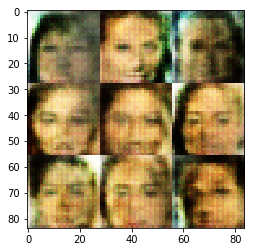

Epoch 1/10... Discriminator Loss: 1.1327... Generator Loss: 0.7833
Epoch 1/10... Discriminator Loss: 1.1372... Generator Loss: 0.9284
Epoch 1/10... Discriminator Loss: 1.1936... Generator Loss: 0.7476
Epoch 1/10... Discriminator Loss: 1.2028... Generator Loss: 0.7773
Epoch 1/10... Discriminator Loss: 1.0144... Generator Loss: 0.9315
Epoch 1/10... Discriminator Loss: 1.2546... Generator Loss: 1.0770
Epoch 1/10... Discriminator Loss: 1.2671... Generator Loss: 1.0018
Epoch 1/10... Discriminator Loss: 1.1917... Generator Loss: 0.7648
Epoch 1/10... Discriminator Loss: 1.3923... Generator Loss: 0.5057
Epoch 1/10... Discriminator Loss: 1.1488... Generator Loss: 0.8324


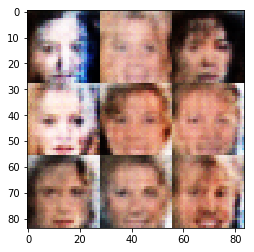

Epoch 1/10... Discriminator Loss: 1.3277... Generator Loss: 0.6718
Epoch 1/10... Discriminator Loss: 1.3498... Generator Loss: 0.8234
Epoch 1/10... Discriminator Loss: 1.2518... Generator Loss: 0.9064
Epoch 1/10... Discriminator Loss: 1.2968... Generator Loss: 0.5711
Epoch 1/10... Discriminator Loss: 1.1641... Generator Loss: 0.9280
Epoch 1/10... Discriminator Loss: 1.3205... Generator Loss: 0.4809
Epoch 1/10... Discriminator Loss: 1.6385... Generator Loss: 0.3486
Epoch 1/10... Discriminator Loss: 1.0169... Generator Loss: 1.1381
Epoch 1/10... Discriminator Loss: 1.1803... Generator Loss: 0.8694
Epoch 1/10... Discriminator Loss: 1.4095... Generator Loss: 1.0453


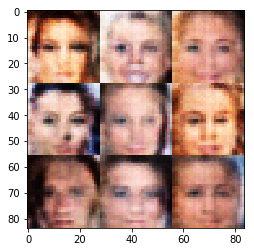

Epoch 1/10... Discriminator Loss: 0.9820... Generator Loss: 1.0703
Epoch 1/10... Discriminator Loss: 1.1543... Generator Loss: 1.1363
Epoch 1/10... Discriminator Loss: 1.2002... Generator Loss: 0.6936
Epoch 1/10... Discriminator Loss: 1.1276... Generator Loss: 0.8382
Epoch 1/10... Discriminator Loss: 1.2404... Generator Loss: 0.6210
Epoch 1/10... Discriminator Loss: 1.1208... Generator Loss: 0.8905
Epoch 1/10... Discriminator Loss: 1.2203... Generator Loss: 0.8144
Epoch 1/10... Discriminator Loss: 1.2212... Generator Loss: 0.7336
Epoch 1/10... Discriminator Loss: 1.2432... Generator Loss: 0.6253
Epoch 1/10... Discriminator Loss: 1.1132... Generator Loss: 0.9639


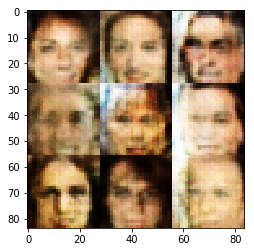

Epoch 1/10... Discriminator Loss: 1.1506... Generator Loss: 0.9960
Epoch 1/10... Discriminator Loss: 1.0401... Generator Loss: 1.0911
Epoch 1/10... Discriminator Loss: 1.1303... Generator Loss: 0.9277
Epoch 1/10... Discriminator Loss: 1.0854... Generator Loss: 0.9316
Epoch 1/10... Discriminator Loss: 1.4767... Generator Loss: 1.0640
Epoch 1/10... Discriminator Loss: 1.1995... Generator Loss: 0.7962
Epoch 1/10... Discriminator Loss: 1.1189... Generator Loss: 1.1817
Epoch 1/10... Discriminator Loss: 1.1425... Generator Loss: 1.2973
Epoch 1/10... Discriminator Loss: 1.3662... Generator Loss: 0.5195
Epoch 1/10... Discriminator Loss: 1.1540... Generator Loss: 0.6871


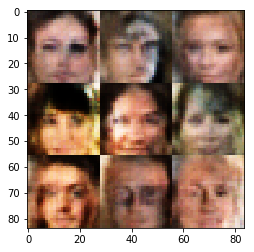

Epoch 1/10... Discriminator Loss: 1.2980... Generator Loss: 0.5558
Epoch 1/10... Discriminator Loss: 1.4919... Generator Loss: 0.4225
Epoch 1/10... Discriminator Loss: 1.1005... Generator Loss: 1.1224
Epoch 1/10... Discriminator Loss: 1.0631... Generator Loss: 1.0244
Epoch 1/10... Discriminator Loss: 1.2756... Generator Loss: 0.7138
Epoch 1/10... Discriminator Loss: 1.1076... Generator Loss: 0.7129
Epoch 1/10... Discriminator Loss: 1.0469... Generator Loss: 1.0912
Epoch 1/10... Discriminator Loss: 1.1513... Generator Loss: 0.7905
Epoch 1/10... Discriminator Loss: 1.1349... Generator Loss: 0.8302
Epoch 1/10... Discriminator Loss: 1.3092... Generator Loss: 1.1608


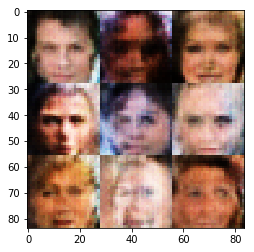

Epoch 1/10... Discriminator Loss: 1.2225... Generator Loss: 1.0588
Epoch 1/10... Discriminator Loss: 1.2013... Generator Loss: 0.6348
Epoch 1/10... Discriminator Loss: 1.0195... Generator Loss: 0.8977
Epoch 1/10... Discriminator Loss: 1.2600... Generator Loss: 0.7049
Epoch 1/10... Discriminator Loss: 1.3284... Generator Loss: 1.6579
Epoch 1/10... Discriminator Loss: 1.0923... Generator Loss: 0.8455
Epoch 1/10... Discriminator Loss: 1.1056... Generator Loss: 0.7056
Epoch 1/10... Discriminator Loss: 1.0198... Generator Loss: 0.7348
Epoch 1/10... Discriminator Loss: 1.2180... Generator Loss: 0.6345
Epoch 1/10... Discriminator Loss: 1.2602... Generator Loss: 0.6901


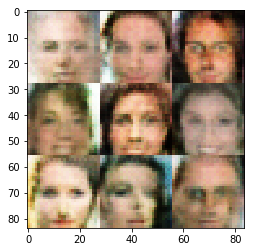

Epoch 1/10... Discriminator Loss: 1.2097... Generator Loss: 0.9647
Epoch 1/10... Discriminator Loss: 1.2583... Generator Loss: 0.7027
Epoch 1/10... Discriminator Loss: 1.1628... Generator Loss: 1.3704
Epoch 1/10... Discriminator Loss: 1.1652... Generator Loss: 0.9310
Epoch 1/10... Discriminator Loss: 1.4619... Generator Loss: 0.4457
Epoch 1/10... Discriminator Loss: 1.2248... Generator Loss: 0.8603
Epoch 1/10... Discriminator Loss: 1.1074... Generator Loss: 0.8922
Epoch 1/10... Discriminator Loss: 1.1629... Generator Loss: 1.0267
Epoch 1/10... Discriminator Loss: 1.2093... Generator Loss: 1.4125
Epoch 1/10... Discriminator Loss: 1.0523... Generator Loss: 0.9799


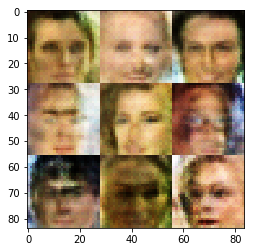

Epoch 1/10... Discriminator Loss: 1.4195... Generator Loss: 0.9247
Epoch 1/10... Discriminator Loss: 1.2566... Generator Loss: 0.5377
Epoch 1/10... Discriminator Loss: 1.1074... Generator Loss: 0.9543
Epoch 1/10... Discriminator Loss: 1.1190... Generator Loss: 0.7059
Epoch 1/10... Discriminator Loss: 1.0637... Generator Loss: 0.8518
Epoch 1/10... Discriminator Loss: 1.1403... Generator Loss: 0.9539
Epoch 1/10... Discriminator Loss: 1.1843... Generator Loss: 0.6669
Epoch 1/10... Discriminator Loss: 1.1371... Generator Loss: 0.7287
Epoch 1/10... Discriminator Loss: 1.1857... Generator Loss: 0.8359
Epoch 1/10... Discriminator Loss: 1.1529... Generator Loss: 0.7424


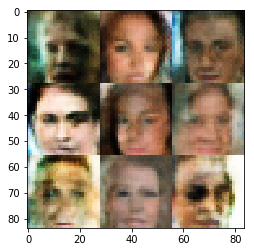

Epoch 1/10... Discriminator Loss: 1.1717... Generator Loss: 0.6939
Epoch 1/10... Discriminator Loss: 1.2096... Generator Loss: 0.6785
Epoch 1/10... Discriminator Loss: 1.2491... Generator Loss: 0.5780
Epoch 1/10... Discriminator Loss: 1.1873... Generator Loss: 1.1697
Epoch 1/10... Discriminator Loss: 1.2698... Generator Loss: 1.3218
Epoch 1/10... Discriminator Loss: 1.2094... Generator Loss: 0.6026
Epoch 1/10... Discriminator Loss: 1.1404... Generator Loss: 0.7258
Epoch 1/10... Discriminator Loss: 1.4164... Generator Loss: 0.9797
Epoch 1/10... Discriminator Loss: 1.1497... Generator Loss: 0.7217
Epoch 1/10... Discriminator Loss: 1.2221... Generator Loss: 1.0689


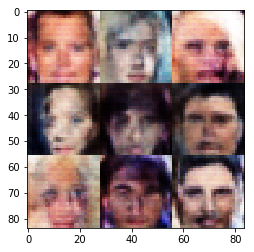

Epoch 1/10... Discriminator Loss: 1.3175... Generator Loss: 1.0342
Epoch 1/10... Discriminator Loss: 1.2604... Generator Loss: 0.5951
Epoch 1/10... Discriminator Loss: 1.0536... Generator Loss: 0.9453
Epoch 1/10... Discriminator Loss: 1.0629... Generator Loss: 0.8204
Epoch 1/10... Discriminator Loss: 1.4170... Generator Loss: 0.4336
Epoch 1/10... Discriminator Loss: 1.1922... Generator Loss: 0.7317
Epoch 1/10... Discriminator Loss: 1.2382... Generator Loss: 0.6307
Epoch 1/10... Discriminator Loss: 1.2258... Generator Loss: 1.3637
Epoch 2/10... Discriminator Loss: 1.1504... Generator Loss: 0.6856
Epoch 2/10... Discriminator Loss: 1.2081... Generator Loss: 0.8626


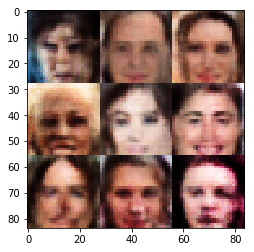

Epoch 2/10... Discriminator Loss: 0.9932... Generator Loss: 1.3061
Epoch 2/10... Discriminator Loss: 1.3171... Generator Loss: 0.5259
Epoch 2/10... Discriminator Loss: 1.1661... Generator Loss: 0.6521
Epoch 2/10... Discriminator Loss: 1.1936... Generator Loss: 0.8787
Epoch 2/10... Discriminator Loss: 1.2370... Generator Loss: 1.4377
Epoch 2/10... Discriminator Loss: 1.1558... Generator Loss: 0.9416
Epoch 2/10... Discriminator Loss: 1.1619... Generator Loss: 0.9569
Epoch 2/10... Discriminator Loss: 1.2503... Generator Loss: 1.2530
Epoch 2/10... Discriminator Loss: 1.1559... Generator Loss: 0.7636
Epoch 2/10... Discriminator Loss: 1.0792... Generator Loss: 0.8556


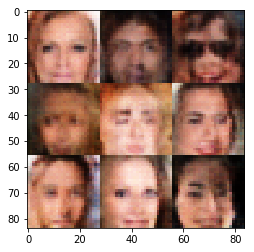

Epoch 2/10... Discriminator Loss: 1.1877... Generator Loss: 0.8218
Epoch 2/10... Discriminator Loss: 1.2476... Generator Loss: 0.7326
Epoch 2/10... Discriminator Loss: 1.1591... Generator Loss: 0.8409
Epoch 2/10... Discriminator Loss: 1.4219... Generator Loss: 0.4272
Epoch 2/10... Discriminator Loss: 1.1150... Generator Loss: 1.0002
Epoch 2/10... Discriminator Loss: 1.0630... Generator Loss: 0.8106
Epoch 2/10... Discriminator Loss: 1.1578... Generator Loss: 0.7277
Epoch 2/10... Discriminator Loss: 1.1323... Generator Loss: 1.1939
Epoch 2/10... Discriminator Loss: 1.1392... Generator Loss: 0.8834
Epoch 2/10... Discriminator Loss: 1.1237... Generator Loss: 1.0448


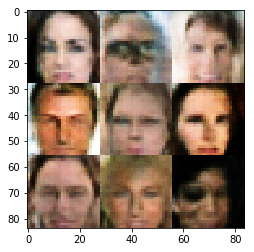

Epoch 2/10... Discriminator Loss: 1.2469... Generator Loss: 0.6446
Epoch 2/10... Discriminator Loss: 1.1649... Generator Loss: 1.0520
Epoch 2/10... Discriminator Loss: 1.3018... Generator Loss: 0.5667
Epoch 2/10... Discriminator Loss: 1.2659... Generator Loss: 0.7885
Epoch 2/10... Discriminator Loss: 1.0929... Generator Loss: 1.1293
Epoch 2/10... Discriminator Loss: 1.2313... Generator Loss: 0.9469
Epoch 2/10... Discriminator Loss: 1.2743... Generator Loss: 0.7754
Epoch 2/10... Discriminator Loss: 1.2122... Generator Loss: 0.7622
Epoch 2/10... Discriminator Loss: 1.2753... Generator Loss: 0.5371
Epoch 2/10... Discriminator Loss: 1.1938... Generator Loss: 1.3521


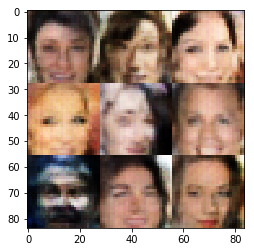

Epoch 2/10... Discriminator Loss: 1.3200... Generator Loss: 0.5475
Epoch 2/10... Discriminator Loss: 1.1219... Generator Loss: 1.1547
Epoch 2/10... Discriminator Loss: 1.0237... Generator Loss: 0.8644
Epoch 2/10... Discriminator Loss: 1.1710... Generator Loss: 1.3372
Epoch 2/10... Discriminator Loss: 1.1469... Generator Loss: 0.9040
Epoch 2/10... Discriminator Loss: 1.4737... Generator Loss: 0.3899
Epoch 2/10... Discriminator Loss: 1.1344... Generator Loss: 1.0192
Epoch 2/10... Discriminator Loss: 1.0884... Generator Loss: 1.1806
Epoch 2/10... Discriminator Loss: 1.2331... Generator Loss: 1.2112
Epoch 2/10... Discriminator Loss: 1.2005... Generator Loss: 0.6038


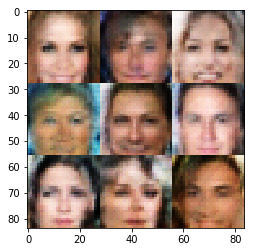

Epoch 2/10... Discriminator Loss: 1.1536... Generator Loss: 0.6986
Epoch 2/10... Discriminator Loss: 1.1051... Generator Loss: 1.0126
Epoch 2/10... Discriminator Loss: 1.2066... Generator Loss: 1.1074
Epoch 2/10... Discriminator Loss: 1.3557... Generator Loss: 1.2828
Epoch 2/10... Discriminator Loss: 1.2194... Generator Loss: 0.6042
Epoch 2/10... Discriminator Loss: 1.4382... Generator Loss: 0.3968
Epoch 2/10... Discriminator Loss: 1.1675... Generator Loss: 0.8075
Epoch 2/10... Discriminator Loss: 1.1453... Generator Loss: 1.0610
Epoch 2/10... Discriminator Loss: 1.0869... Generator Loss: 0.8252
Epoch 2/10... Discriminator Loss: 1.1628... Generator Loss: 1.1106


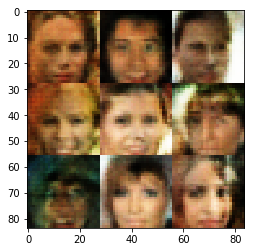

Epoch 2/10... Discriminator Loss: 1.4577... Generator Loss: 0.4056
Epoch 2/10... Discriminator Loss: 1.2520... Generator Loss: 1.1679
Epoch 2/10... Discriminator Loss: 1.2658... Generator Loss: 0.6690
Epoch 2/10... Discriminator Loss: 1.3055... Generator Loss: 0.7232
Epoch 2/10... Discriminator Loss: 1.1848... Generator Loss: 1.2605
Epoch 2/10... Discriminator Loss: 1.1094... Generator Loss: 0.8244
Epoch 2/10... Discriminator Loss: 1.1743... Generator Loss: 1.4313
Epoch 2/10... Discriminator Loss: 1.2081... Generator Loss: 1.0431
Epoch 2/10... Discriminator Loss: 1.3378... Generator Loss: 0.4806
Epoch 2/10... Discriminator Loss: 1.1012... Generator Loss: 0.7794


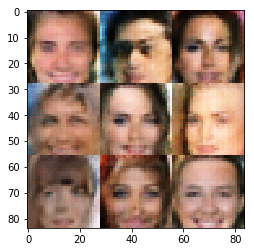

Epoch 2/10... Discriminator Loss: 1.1672... Generator Loss: 0.7870
Epoch 2/10... Discriminator Loss: 1.1584... Generator Loss: 0.8564
Epoch 2/10... Discriminator Loss: 1.2266... Generator Loss: 0.6787
Epoch 2/10... Discriminator Loss: 1.2868... Generator Loss: 1.7101
Epoch 2/10... Discriminator Loss: 1.2740... Generator Loss: 0.5105
Epoch 2/10... Discriminator Loss: 1.1471... Generator Loss: 0.6723
Epoch 2/10... Discriminator Loss: 1.1836... Generator Loss: 0.6171
Epoch 2/10... Discriminator Loss: 1.1538... Generator Loss: 0.8153
Epoch 2/10... Discriminator Loss: 1.2505... Generator Loss: 0.5296
Epoch 2/10... Discriminator Loss: 1.0838... Generator Loss: 0.9143


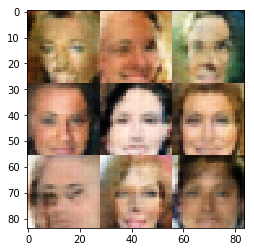

Epoch 2/10... Discriminator Loss: 1.1985... Generator Loss: 1.1307
Epoch 2/10... Discriminator Loss: 1.1913... Generator Loss: 0.8490
Epoch 2/10... Discriminator Loss: 1.2049... Generator Loss: 0.9622
Epoch 2/10... Discriminator Loss: 1.3324... Generator Loss: 0.5890
Epoch 2/10... Discriminator Loss: 1.2094... Generator Loss: 0.7398
Epoch 2/10... Discriminator Loss: 1.0784... Generator Loss: 0.8912
Epoch 2/10... Discriminator Loss: 1.1169... Generator Loss: 0.6955
Epoch 2/10... Discriminator Loss: 1.1941... Generator Loss: 1.1225
Epoch 2/10... Discriminator Loss: 1.1932... Generator Loss: 1.3077
Epoch 2/10... Discriminator Loss: 1.1125... Generator Loss: 0.9667


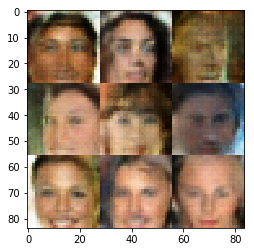

Epoch 2/10... Discriminator Loss: 1.3023... Generator Loss: 0.7567
Epoch 2/10... Discriminator Loss: 1.1189... Generator Loss: 0.8291
Epoch 2/10... Discriminator Loss: 1.1538... Generator Loss: 1.0039
Epoch 2/10... Discriminator Loss: 1.0318... Generator Loss: 0.8537
Epoch 2/10... Discriminator Loss: 1.0764... Generator Loss: 0.9969
Epoch 2/10... Discriminator Loss: 1.2247... Generator Loss: 0.5691
Epoch 2/10... Discriminator Loss: 1.2381... Generator Loss: 0.5880
Epoch 2/10... Discriminator Loss: 1.1295... Generator Loss: 0.7353
Epoch 2/10... Discriminator Loss: 1.1357... Generator Loss: 0.8132
Epoch 2/10... Discriminator Loss: 1.2340... Generator Loss: 1.0751


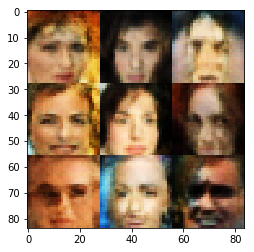

Epoch 2/10... Discriminator Loss: 1.3805... Generator Loss: 0.4509
Epoch 2/10... Discriminator Loss: 1.2200... Generator Loss: 0.7945
Epoch 2/10... Discriminator Loss: 1.1418... Generator Loss: 0.7898
Epoch 2/10... Discriminator Loss: 1.2032... Generator Loss: 0.5278
Epoch 2/10... Discriminator Loss: 1.2352... Generator Loss: 1.4052
Epoch 2/10... Discriminator Loss: 1.3643... Generator Loss: 1.2607
Epoch 2/10... Discriminator Loss: 1.1472... Generator Loss: 0.7399
Epoch 2/10... Discriminator Loss: 1.1657... Generator Loss: 0.7258
Epoch 2/10... Discriminator Loss: 1.1610... Generator Loss: 0.6720
Epoch 2/10... Discriminator Loss: 1.3923... Generator Loss: 1.4186


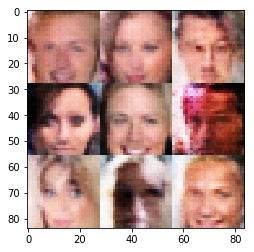

Epoch 2/10... Discriminator Loss: 1.1984... Generator Loss: 0.9642
Epoch 2/10... Discriminator Loss: 1.2661... Generator Loss: 0.8014
Epoch 2/10... Discriminator Loss: 1.1954... Generator Loss: 0.7891
Epoch 2/10... Discriminator Loss: 1.1654... Generator Loss: 0.7667
Epoch 2/10... Discriminator Loss: 1.0513... Generator Loss: 1.0423
Epoch 2/10... Discriminator Loss: 1.2863... Generator Loss: 1.3585
Epoch 2/10... Discriminator Loss: 1.1824... Generator Loss: 0.5997
Epoch 2/10... Discriminator Loss: 1.1843... Generator Loss: 1.0753
Epoch 2/10... Discriminator Loss: 1.2762... Generator Loss: 1.0004
Epoch 2/10... Discriminator Loss: 1.2270... Generator Loss: 0.5778


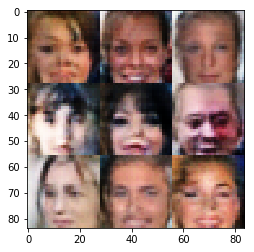

Epoch 2/10... Discriminator Loss: 1.5477... Generator Loss: 0.3604
Epoch 2/10... Discriminator Loss: 1.3080... Generator Loss: 0.5561
Epoch 2/10... Discriminator Loss: 1.2655... Generator Loss: 0.6788
Epoch 2/10... Discriminator Loss: 1.1847... Generator Loss: 0.8524
Epoch 2/10... Discriminator Loss: 1.2254... Generator Loss: 0.7886
Epoch 2/10... Discriminator Loss: 1.2675... Generator Loss: 0.8119
Epoch 2/10... Discriminator Loss: 1.2655... Generator Loss: 0.6394
Epoch 2/10... Discriminator Loss: 1.1847... Generator Loss: 0.6587
Epoch 2/10... Discriminator Loss: 1.2209... Generator Loss: 0.9245
Epoch 2/10... Discriminator Loss: 1.2302... Generator Loss: 0.7411


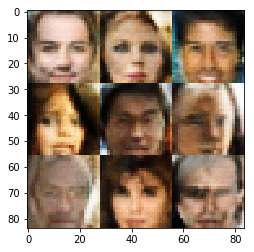

Epoch 2/10... Discriminator Loss: 1.4354... Generator Loss: 0.4295
Epoch 2/10... Discriminator Loss: 1.3707... Generator Loss: 0.6953
Epoch 2/10... Discriminator Loss: 1.1904... Generator Loss: 0.8426
Epoch 2/10... Discriminator Loss: 1.1784... Generator Loss: 0.7008
Epoch 2/10... Discriminator Loss: 1.1416... Generator Loss: 0.7494
Epoch 2/10... Discriminator Loss: 1.2328... Generator Loss: 1.0897
Epoch 2/10... Discriminator Loss: 1.2030... Generator Loss: 0.7175
Epoch 2/10... Discriminator Loss: 1.3221... Generator Loss: 0.8868
Epoch 2/10... Discriminator Loss: 1.2804... Generator Loss: 0.7431
Epoch 2/10... Discriminator Loss: 1.1333... Generator Loss: 0.8314


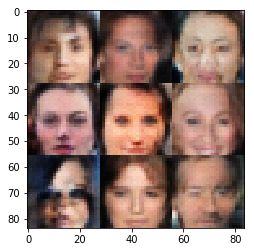

Epoch 2/10... Discriminator Loss: 1.1646... Generator Loss: 0.6507
Epoch 2/10... Discriminator Loss: 1.3219... Generator Loss: 0.8563
Epoch 2/10... Discriminator Loss: 1.1864... Generator Loss: 0.8418
Epoch 2/10... Discriminator Loss: 1.1025... Generator Loss: 0.8736
Epoch 2/10... Discriminator Loss: 1.1202... Generator Loss: 0.8587
Epoch 2/10... Discriminator Loss: 1.0965... Generator Loss: 0.9091
Epoch 2/10... Discriminator Loss: 1.1568... Generator Loss: 0.9016
Epoch 2/10... Discriminator Loss: 1.1774... Generator Loss: 0.6084
Epoch 2/10... Discriminator Loss: 1.3634... Generator Loss: 0.5143
Epoch 2/10... Discriminator Loss: 1.1760... Generator Loss: 0.6752


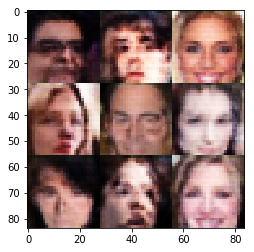

Epoch 2/10... Discriminator Loss: 1.4141... Generator Loss: 0.4458
Epoch 2/10... Discriminator Loss: 1.1042... Generator Loss: 0.7862
Epoch 2/10... Discriminator Loss: 1.2876... Generator Loss: 0.6199
Epoch 2/10... Discriminator Loss: 1.1624... Generator Loss: 1.0072
Epoch 2/10... Discriminator Loss: 1.3868... Generator Loss: 0.4766
Epoch 2/10... Discriminator Loss: 1.1195... Generator Loss: 0.8474
Epoch 2/10... Discriminator Loss: 1.2718... Generator Loss: 0.6827
Epoch 2/10... Discriminator Loss: 1.1691... Generator Loss: 1.0288
Epoch 2/10... Discriminator Loss: 1.0664... Generator Loss: 0.8460
Epoch 2/10... Discriminator Loss: 1.1924... Generator Loss: 0.9367


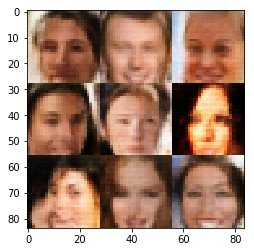

Epoch 2/10... Discriminator Loss: 1.1906... Generator Loss: 0.9658
Epoch 2/10... Discriminator Loss: 1.8101... Generator Loss: 0.2549
Epoch 2/10... Discriminator Loss: 1.1542... Generator Loss: 0.9494
Epoch 2/10... Discriminator Loss: 1.2482... Generator Loss: 0.8284
Epoch 2/10... Discriminator Loss: 1.2657... Generator Loss: 0.7724
Epoch 2/10... Discriminator Loss: 1.0875... Generator Loss: 0.8931
Epoch 3/10... Discriminator Loss: 1.1799... Generator Loss: 0.6613
Epoch 3/10... Discriminator Loss: 1.2696... Generator Loss: 0.5068
Epoch 3/10... Discriminator Loss: 1.1720... Generator Loss: 0.7014
Epoch 3/10... Discriminator Loss: 1.2604... Generator Loss: 0.5224


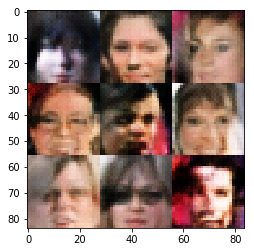

Epoch 3/10... Discriminator Loss: 1.3180... Generator Loss: 0.6318
Epoch 3/10... Discriminator Loss: 1.0759... Generator Loss: 1.0424
Epoch 3/10... Discriminator Loss: 1.1515... Generator Loss: 0.7314
Epoch 3/10... Discriminator Loss: 1.0745... Generator Loss: 0.9713
Epoch 3/10... Discriminator Loss: 1.2638... Generator Loss: 0.6167
Epoch 3/10... Discriminator Loss: 1.2714... Generator Loss: 1.2027
Epoch 3/10... Discriminator Loss: 1.1937... Generator Loss: 0.7849
Epoch 3/10... Discriminator Loss: 1.2382... Generator Loss: 1.3554
Epoch 3/10... Discriminator Loss: 1.2429... Generator Loss: 0.8750
Epoch 3/10... Discriminator Loss: 1.1403... Generator Loss: 0.9185


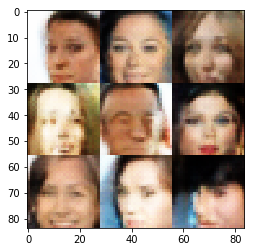

Epoch 3/10... Discriminator Loss: 1.2736... Generator Loss: 0.8005
Epoch 3/10... Discriminator Loss: 1.2041... Generator Loss: 1.1316
Epoch 3/10... Discriminator Loss: 1.3013... Generator Loss: 0.5762
Epoch 3/10... Discriminator Loss: 1.0216... Generator Loss: 0.7404
Epoch 3/10... Discriminator Loss: 1.0779... Generator Loss: 1.8171
Epoch 3/10... Discriminator Loss: 1.2858... Generator Loss: 0.9704
Epoch 3/10... Discriminator Loss: 1.1991... Generator Loss: 0.7945
Epoch 3/10... Discriminator Loss: 1.1630... Generator Loss: 0.5794
Epoch 3/10... Discriminator Loss: 1.1161... Generator Loss: 0.6814
Epoch 3/10... Discriminator Loss: 1.2492... Generator Loss: 0.9146


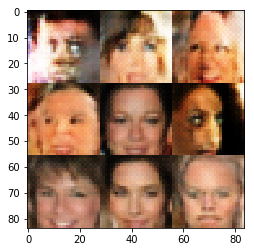

Epoch 3/10... Discriminator Loss: 1.0021... Generator Loss: 1.2248
Epoch 3/10... Discriminator Loss: 1.2341... Generator Loss: 0.4747
Epoch 3/10... Discriminator Loss: 1.3598... Generator Loss: 0.8592
Epoch 3/10... Discriminator Loss: 1.4602... Generator Loss: 0.3581
Epoch 3/10... Discriminator Loss: 1.3465... Generator Loss: 0.7630
Epoch 3/10... Discriminator Loss: 1.2296... Generator Loss: 0.9115
Epoch 3/10... Discriminator Loss: 1.1095... Generator Loss: 1.0799
Epoch 3/10... Discriminator Loss: 1.3394... Generator Loss: 0.4614
Epoch 3/10... Discriminator Loss: 1.1966... Generator Loss: 0.6058
Epoch 3/10... Discriminator Loss: 1.8236... Generator Loss: 0.2866


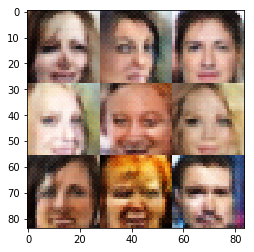

Epoch 3/10... Discriminator Loss: 0.9148... Generator Loss: 0.9570
Epoch 3/10... Discriminator Loss: 1.0024... Generator Loss: 1.1435
Epoch 3/10... Discriminator Loss: 0.9071... Generator Loss: 1.1975
Epoch 3/10... Discriminator Loss: 1.3120... Generator Loss: 1.1003
Epoch 3/10... Discriminator Loss: 1.0939... Generator Loss: 0.7769
Epoch 3/10... Discriminator Loss: 1.3900... Generator Loss: 1.2056
Epoch 3/10... Discriminator Loss: 0.8524... Generator Loss: 1.2705
Epoch 3/10... Discriminator Loss: 1.3033... Generator Loss: 0.4417
Epoch 3/10... Discriminator Loss: 1.1254... Generator Loss: 0.6727
Epoch 3/10... Discriminator Loss: 1.0705... Generator Loss: 0.7591


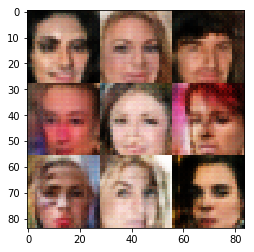

Epoch 3/10... Discriminator Loss: 1.4862... Generator Loss: 1.8145
Epoch 3/10... Discriminator Loss: 0.8435... Generator Loss: 0.9402
Epoch 3/10... Discriminator Loss: 1.1387... Generator Loss: 0.7672
Epoch 3/10... Discriminator Loss: 1.6754... Generator Loss: 1.8275
Epoch 3/10... Discriminator Loss: 1.3786... Generator Loss: 1.1171
Epoch 3/10... Discriminator Loss: 0.8210... Generator Loss: 1.3407
Epoch 3/10... Discriminator Loss: 1.2206... Generator Loss: 0.6175
Epoch 3/10... Discriminator Loss: 1.2196... Generator Loss: 0.8325
Epoch 3/10... Discriminator Loss: 1.3453... Generator Loss: 0.7104
Epoch 3/10... Discriminator Loss: 1.2437... Generator Loss: 1.1092


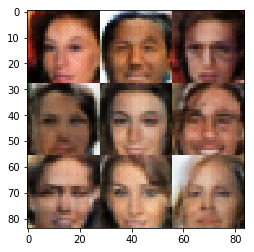

Epoch 3/10... Discriminator Loss: 1.1183... Generator Loss: 0.7283
Epoch 3/10... Discriminator Loss: 1.3401... Generator Loss: 0.5260
Epoch 3/10... Discriminator Loss: 1.1451... Generator Loss: 0.5564
Epoch 3/10... Discriminator Loss: 1.2452... Generator Loss: 2.3603
Epoch 3/10... Discriminator Loss: 1.6857... Generator Loss: 1.9123
Epoch 3/10... Discriminator Loss: 0.8144... Generator Loss: 0.7816
Epoch 3/10... Discriminator Loss: 2.0934... Generator Loss: 3.1212
Epoch 3/10... Discriminator Loss: 0.6799... Generator Loss: 1.2943
Epoch 3/10... Discriminator Loss: 1.3919... Generator Loss: 0.6202
Epoch 3/10... Discriminator Loss: 1.2579... Generator Loss: 0.6750


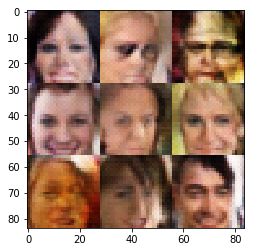

Epoch 3/10... Discriminator Loss: 0.9939... Generator Loss: 0.7354
Epoch 3/10... Discriminator Loss: 0.8353... Generator Loss: 2.1325
Epoch 3/10... Discriminator Loss: 1.2591... Generator Loss: 0.5062
Epoch 3/10... Discriminator Loss: 0.8226... Generator Loss: 1.1693
Epoch 3/10... Discriminator Loss: 0.7954... Generator Loss: 1.3343
Epoch 3/10... Discriminator Loss: 0.4939... Generator Loss: 1.9350
Epoch 3/10... Discriminator Loss: 1.3496... Generator Loss: 0.6047
Epoch 3/10... Discriminator Loss: 1.4323... Generator Loss: 0.9628
Epoch 3/10... Discriminator Loss: 1.2658... Generator Loss: 0.8367
Epoch 3/10... Discriminator Loss: 1.3957... Generator Loss: 0.8074


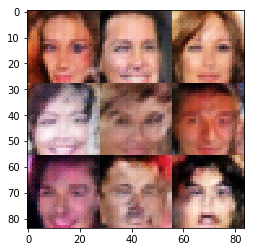

Epoch 3/10... Discriminator Loss: 1.3324... Generator Loss: 0.7105
Epoch 3/10... Discriminator Loss: 1.1785... Generator Loss: 0.7433
Epoch 3/10... Discriminator Loss: 1.2365... Generator Loss: 0.7105
Epoch 3/10... Discriminator Loss: 1.3045... Generator Loss: 0.6821
Epoch 3/10... Discriminator Loss: 1.2586... Generator Loss: 0.6809
Epoch 3/10... Discriminator Loss: 1.1710... Generator Loss: 0.9468
Epoch 3/10... Discriminator Loss: 1.2109... Generator Loss: 0.7493
Epoch 3/10... Discriminator Loss: 1.2239... Generator Loss: 0.7566
Epoch 3/10... Discriminator Loss: 1.2120... Generator Loss: 0.7680
Epoch 3/10... Discriminator Loss: 1.1347... Generator Loss: 0.8926


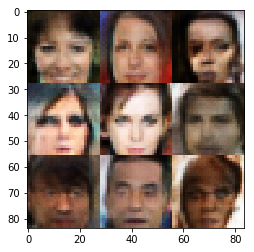

Epoch 3/10... Discriminator Loss: 1.2583... Generator Loss: 0.7620
Epoch 3/10... Discriminator Loss: 1.2779... Generator Loss: 0.8433
Epoch 3/10... Discriminator Loss: 1.1201... Generator Loss: 0.8000
Epoch 3/10... Discriminator Loss: 1.1421... Generator Loss: 0.7195
Epoch 3/10... Discriminator Loss: 1.2240... Generator Loss: 0.5759
Epoch 3/10... Discriminator Loss: 1.1827... Generator Loss: 0.7841
Epoch 3/10... Discriminator Loss: 1.2406... Generator Loss: 0.6347
Epoch 3/10... Discriminator Loss: 1.2312... Generator Loss: 0.9488
Epoch 3/10... Discriminator Loss: 1.2058... Generator Loss: 0.7846
Epoch 3/10... Discriminator Loss: 1.2704... Generator Loss: 1.0173


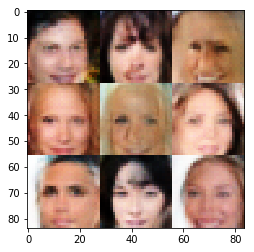

Epoch 3/10... Discriminator Loss: 1.1459... Generator Loss: 0.9864
Epoch 3/10... Discriminator Loss: 1.1515... Generator Loss: 0.9004
Epoch 3/10... Discriminator Loss: 1.1837... Generator Loss: 0.7418
Epoch 3/10... Discriminator Loss: 1.1121... Generator Loss: 0.6945
Epoch 3/10... Discriminator Loss: 1.2298... Generator Loss: 0.8299
Epoch 3/10... Discriminator Loss: 1.1509... Generator Loss: 0.7160
Epoch 3/10... Discriminator Loss: 1.2286... Generator Loss: 0.8492
Epoch 3/10... Discriminator Loss: 1.2223... Generator Loss: 0.7963
Epoch 3/10... Discriminator Loss: 1.2079... Generator Loss: 0.6837
Epoch 3/10... Discriminator Loss: 1.2351... Generator Loss: 0.8215


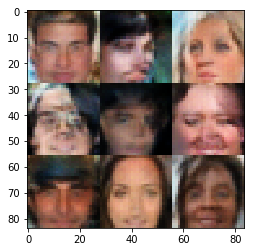

Epoch 3/10... Discriminator Loss: 1.1124... Generator Loss: 0.7928
Epoch 3/10... Discriminator Loss: 1.2471... Generator Loss: 0.8739
Epoch 3/10... Discriminator Loss: 1.2208... Generator Loss: 0.6278
Epoch 3/10... Discriminator Loss: 1.5140... Generator Loss: 1.5173
Epoch 3/10... Discriminator Loss: 1.2396... Generator Loss: 0.6983
Epoch 3/10... Discriminator Loss: 1.1490... Generator Loss: 1.1144
Epoch 3/10... Discriminator Loss: 1.2118... Generator Loss: 0.8315
Epoch 3/10... Discriminator Loss: 1.2438... Generator Loss: 0.7185
Epoch 3/10... Discriminator Loss: 1.2576... Generator Loss: 0.8521
Epoch 3/10... Discriminator Loss: 1.2167... Generator Loss: 0.8819


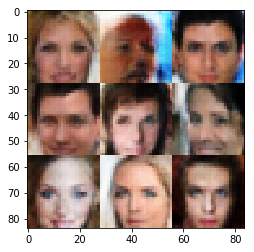

Epoch 3/10... Discriminator Loss: 1.2473... Generator Loss: 0.7996
Epoch 3/10... Discriminator Loss: 1.3530... Generator Loss: 0.8629
Epoch 3/10... Discriminator Loss: 1.0968... Generator Loss: 0.9473
Epoch 3/10... Discriminator Loss: 1.1840... Generator Loss: 1.0767
Epoch 3/10... Discriminator Loss: 1.2525... Generator Loss: 0.6101
Epoch 3/10... Discriminator Loss: 1.1980... Generator Loss: 0.7538
Epoch 3/10... Discriminator Loss: 1.2146... Generator Loss: 0.9408
Epoch 3/10... Discriminator Loss: 1.2197... Generator Loss: 0.7858
Epoch 3/10... Discriminator Loss: 1.1025... Generator Loss: 0.8133
Epoch 3/10... Discriminator Loss: 1.1677... Generator Loss: 0.9068


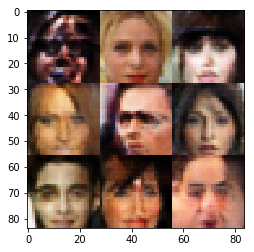

Epoch 3/10... Discriminator Loss: 1.0889... Generator Loss: 0.8861
Epoch 3/10... Discriminator Loss: 0.7714... Generator Loss: 0.8056
Epoch 3/10... Discriminator Loss: 0.4601... Generator Loss: 1.4689
Epoch 3/10... Discriminator Loss: 1.0299... Generator Loss: 0.5406
Epoch 3/10... Discriminator Loss: 1.0084... Generator Loss: 0.6039
Epoch 4/10... Discriminator Loss: 1.4030... Generator Loss: 4.3082
Epoch 4/10... Discriminator Loss: 0.7616... Generator Loss: 1.3141
Epoch 4/10... Discriminator Loss: 0.3229... Generator Loss: 1.8717
Epoch 4/10... Discriminator Loss: 0.5125... Generator Loss: 1.1084
Epoch 4/10... Discriminator Loss: 0.5735... Generator Loss: 1.1602
Epoch 4/10... Discriminator Loss: 1.8998... Generator Loss: 2.7913


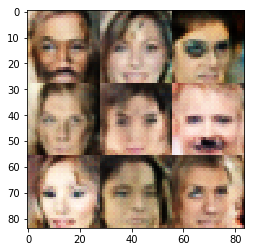

Epoch 4/10... Discriminator Loss: 1.0239... Generator Loss: 0.5993
Epoch 4/10... Discriminator Loss: 1.1036... Generator Loss: 0.5036
Epoch 4/10... Discriminator Loss: 0.3233... Generator Loss: 1.7519
Epoch 4/10... Discriminator Loss: 0.6308... Generator Loss: 0.9397
Epoch 4/10... Discriminator Loss: 0.8281... Generator Loss: 0.7521
Epoch 4/10... Discriminator Loss: 1.3445... Generator Loss: 1.7096
Epoch 4/10... Discriminator Loss: 0.2202... Generator Loss: 4.9654
Epoch 4/10... Discriminator Loss: 0.8189... Generator Loss: 1.7003
Epoch 4/10... Discriminator Loss: 0.2834... Generator Loss: 3.7040
Epoch 4/10... Discriminator Loss: 1.3303... Generator Loss: 0.6415


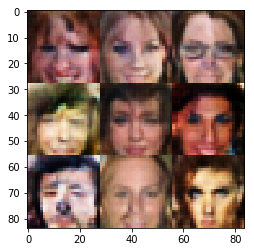

Epoch 4/10... Discriminator Loss: 0.6982... Generator Loss: 1.6042
Epoch 4/10... Discriminator Loss: 0.3229... Generator Loss: 2.6281
Epoch 4/10... Discriminator Loss: 0.6461... Generator Loss: 2.4914
Epoch 4/10... Discriminator Loss: 1.0078... Generator Loss: 2.3632
Epoch 4/10... Discriminator Loss: 1.0237... Generator Loss: 1.0372
Epoch 4/10... Discriminator Loss: 0.3797... Generator Loss: 1.9342
Epoch 4/10... Discriminator Loss: 0.3114... Generator Loss: 2.0245
Epoch 4/10... Discriminator Loss: 0.3598... Generator Loss: 2.1251
Epoch 4/10... Discriminator Loss: 1.6626... Generator Loss: 0.2706
Epoch 4/10... Discriminator Loss: 0.4352... Generator Loss: 2.6787


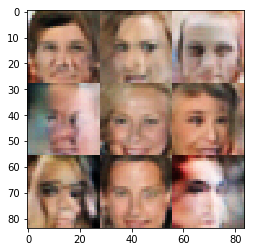

Epoch 4/10... Discriminator Loss: 0.9636... Generator Loss: 1.7136
Epoch 4/10... Discriminator Loss: 0.4398... Generator Loss: 1.4903
Epoch 4/10... Discriminator Loss: 0.3519... Generator Loss: 2.0327
Epoch 4/10... Discriminator Loss: 0.6576... Generator Loss: 1.0276
Epoch 4/10... Discriminator Loss: 0.3483... Generator Loss: 2.1219
Epoch 4/10... Discriminator Loss: 0.8940... Generator Loss: 3.1838
Epoch 4/10... Discriminator Loss: 4.0316... Generator Loss: 3.1538
Epoch 4/10... Discriminator Loss: 0.8229... Generator Loss: 0.8642
Epoch 4/10... Discriminator Loss: 1.4564... Generator Loss: 0.6441
Epoch 4/10... Discriminator Loss: 0.3563... Generator Loss: 4.9177


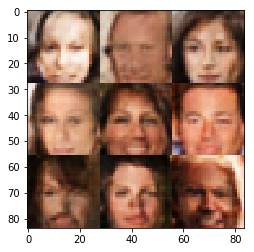

Epoch 4/10... Discriminator Loss: 0.8650... Generator Loss: 3.5516
Epoch 4/10... Discriminator Loss: 0.8627... Generator Loss: 0.7474
Epoch 4/10... Discriminator Loss: 0.8495... Generator Loss: 3.2041
Epoch 4/10... Discriminator Loss: 0.7078... Generator Loss: 4.2513
Epoch 4/10... Discriminator Loss: 0.9704... Generator Loss: 0.6526
Epoch 4/10... Discriminator Loss: 1.8852... Generator Loss: 0.2137
Epoch 4/10... Discriminator Loss: 1.1573... Generator Loss: 0.5626
Epoch 4/10... Discriminator Loss: 1.2748... Generator Loss: 0.4271
Epoch 4/10... Discriminator Loss: 0.7083... Generator Loss: 0.8416
Epoch 4/10... Discriminator Loss: 0.3858... Generator Loss: 1.3724


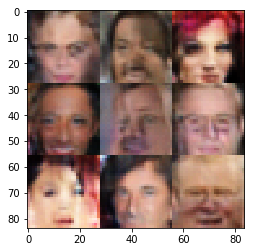

Epoch 4/10... Discriminator Loss: 0.7782... Generator Loss: 3.3028
Epoch 4/10... Discriminator Loss: 0.4801... Generator Loss: 1.5599
Epoch 4/10... Discriminator Loss: 1.1481... Generator Loss: 0.5461
Epoch 4/10... Discriminator Loss: 1.8377... Generator Loss: 0.2255
Epoch 4/10... Discriminator Loss: 0.8091... Generator Loss: 2.1415
Epoch 4/10... Discriminator Loss: 0.6574... Generator Loss: 0.9267
Epoch 4/10... Discriminator Loss: 0.8663... Generator Loss: 0.8187
Epoch 4/10... Discriminator Loss: 0.8958... Generator Loss: 0.7238
Epoch 4/10... Discriminator Loss: 1.9078... Generator Loss: 1.3003
Epoch 4/10... Discriminator Loss: 0.9654... Generator Loss: 1.0181


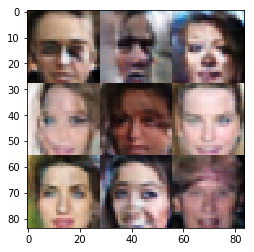

Epoch 4/10... Discriminator Loss: 1.1935... Generator Loss: 3.6377
Epoch 4/10... Discriminator Loss: 0.8796... Generator Loss: 0.7000
Epoch 4/10... Discriminator Loss: 0.3961... Generator Loss: 2.0913
Epoch 4/10... Discriminator Loss: 0.7827... Generator Loss: 1.0094
Epoch 4/10... Discriminator Loss: 0.3531... Generator Loss: 2.1303
Epoch 4/10... Discriminator Loss: 0.8436... Generator Loss: 0.9146
Epoch 4/10... Discriminator Loss: 1.2915... Generator Loss: 0.6235
Epoch 4/10... Discriminator Loss: 0.4868... Generator Loss: 1.8067
Epoch 4/10... Discriminator Loss: 0.8928... Generator Loss: 2.0695
Epoch 4/10... Discriminator Loss: 0.6517... Generator Loss: 1.0533


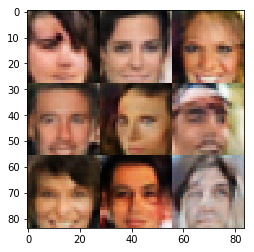

Epoch 4/10... Discriminator Loss: 0.8782... Generator Loss: 2.5541
Epoch 4/10... Discriminator Loss: 0.6201... Generator Loss: 1.3283
Epoch 4/10... Discriminator Loss: 0.5681... Generator Loss: 2.0335
Epoch 4/10... Discriminator Loss: 0.4495... Generator Loss: 2.9467
Epoch 4/10... Discriminator Loss: 0.5412... Generator Loss: 2.8853
Epoch 4/10... Discriminator Loss: 0.3285... Generator Loss: 1.8770
Epoch 4/10... Discriminator Loss: 0.3560... Generator Loss: 3.4430
Epoch 4/10... Discriminator Loss: 0.7091... Generator Loss: 5.4056
Epoch 4/10... Discriminator Loss: 1.3541... Generator Loss: 2.0944
Epoch 4/10... Discriminator Loss: 0.8700... Generator Loss: 3.1183


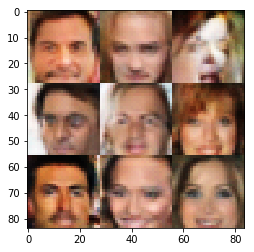

Epoch 4/10... Discriminator Loss: 0.3519... Generator Loss: 1.5965
Epoch 4/10... Discriminator Loss: 0.3584... Generator Loss: 2.3741
Epoch 4/10... Discriminator Loss: 1.1915... Generator Loss: 0.5329
Epoch 4/10... Discriminator Loss: 1.5646... Generator Loss: 1.8334
Epoch 4/10... Discriminator Loss: 0.7182... Generator Loss: 1.5238
Epoch 4/10... Discriminator Loss: 0.6094... Generator Loss: 3.7046
Epoch 4/10... Discriminator Loss: 1.4106... Generator Loss: 0.4103
Epoch 4/10... Discriminator Loss: 0.5835... Generator Loss: 1.2640
Epoch 4/10... Discriminator Loss: 0.4705... Generator Loss: 2.0945
Epoch 4/10... Discriminator Loss: 1.7144... Generator Loss: 0.2750


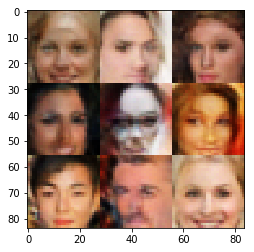

Epoch 4/10... Discriminator Loss: 0.8955... Generator Loss: 0.8398
Epoch 4/10... Discriminator Loss: 1.3917... Generator Loss: 1.8767
Epoch 4/10... Discriminator Loss: 0.6846... Generator Loss: 2.5723
Epoch 4/10... Discriminator Loss: 0.8380... Generator Loss: 3.6407
Epoch 4/10... Discriminator Loss: 1.1918... Generator Loss: 0.4949
Epoch 4/10... Discriminator Loss: 0.9375... Generator Loss: 0.8994
Epoch 4/10... Discriminator Loss: 0.5209... Generator Loss: 4.3087
Epoch 4/10... Discriminator Loss: 0.8914... Generator Loss: 2.9411
Epoch 4/10... Discriminator Loss: 0.3792... Generator Loss: 1.6347
Epoch 4/10... Discriminator Loss: 0.4259... Generator Loss: 2.0352


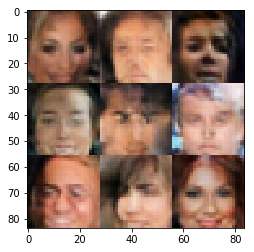

Epoch 4/10... Discriminator Loss: 1.0361... Generator Loss: 3.2219
Epoch 4/10... Discriminator Loss: 0.9146... Generator Loss: 1.4482
Epoch 4/10... Discriminator Loss: 1.2439... Generator Loss: 0.5919
Epoch 4/10... Discriminator Loss: 0.5356... Generator Loss: 1.3338
Epoch 4/10... Discriminator Loss: 0.6140... Generator Loss: 1.2024
Epoch 4/10... Discriminator Loss: 0.7966... Generator Loss: 2.0287
Epoch 4/10... Discriminator Loss: 0.4373... Generator Loss: 1.5195
Epoch 4/10... Discriminator Loss: 0.9779... Generator Loss: 1.3958
Epoch 4/10... Discriminator Loss: 0.5197... Generator Loss: 1.8836
Epoch 4/10... Discriminator Loss: 1.3962... Generator Loss: 0.4170


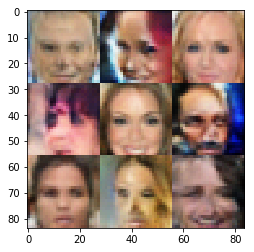

Epoch 4/10... Discriminator Loss: 1.0016... Generator Loss: 4.8569
Epoch 4/10... Discriminator Loss: 0.4028... Generator Loss: 2.2308
Epoch 4/10... Discriminator Loss: 1.7353... Generator Loss: 0.2659
Epoch 4/10... Discriminator Loss: 1.0220... Generator Loss: 1.2261
Epoch 4/10... Discriminator Loss: 0.7453... Generator Loss: 1.0309
Epoch 4/10... Discriminator Loss: 1.1759... Generator Loss: 0.7525
Epoch 4/10... Discriminator Loss: 0.4795... Generator Loss: 2.0861
Epoch 4/10... Discriminator Loss: 1.1153... Generator Loss: 0.5381
Epoch 4/10... Discriminator Loss: 1.3334... Generator Loss: 0.4298
Epoch 4/10... Discriminator Loss: 1.2128... Generator Loss: 3.1854


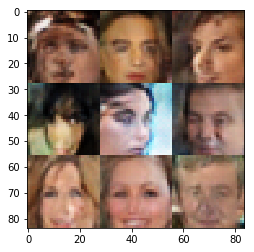

Epoch 4/10... Discriminator Loss: 0.6744... Generator Loss: 1.1289
Epoch 4/10... Discriminator Loss: 1.4435... Generator Loss: 2.3188
Epoch 4/10... Discriminator Loss: 1.3698... Generator Loss: 0.9190
Epoch 4/10... Discriminator Loss: 1.0992... Generator Loss: 0.5905
Epoch 4/10... Discriminator Loss: 0.7171... Generator Loss: 2.5028
Epoch 4/10... Discriminator Loss: 0.5827... Generator Loss: 1.3208
Epoch 4/10... Discriminator Loss: 1.1185... Generator Loss: 0.5314
Epoch 4/10... Discriminator Loss: 0.6074... Generator Loss: 1.7389
Epoch 4/10... Discriminator Loss: 0.5740... Generator Loss: 1.4787
Epoch 4/10... Discriminator Loss: 0.5891... Generator Loss: 1.4122


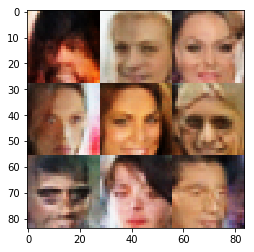

Epoch 4/10... Discriminator Loss: 0.4860... Generator Loss: 2.7002
Epoch 4/10... Discriminator Loss: 0.4260... Generator Loss: 1.7683
Epoch 4/10... Discriminator Loss: 0.7183... Generator Loss: 2.8844
Epoch 4/10... Discriminator Loss: 0.8110... Generator Loss: 0.8883
Epoch 4/10... Discriminator Loss: 0.7850... Generator Loss: 2.4010
Epoch 4/10... Discriminator Loss: 0.7747... Generator Loss: 1.7920
Epoch 4/10... Discriminator Loss: 0.4818... Generator Loss: 2.0444
Epoch 4/10... Discriminator Loss: 0.5243... Generator Loss: 2.7919
Epoch 4/10... Discriminator Loss: 1.3116... Generator Loss: 0.4327
Epoch 4/10... Discriminator Loss: 1.1836... Generator Loss: 0.5258


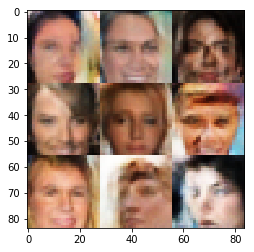

Epoch 4/10... Discriminator Loss: 0.7367... Generator Loss: 1.2061
Epoch 4/10... Discriminator Loss: 0.7004... Generator Loss: 1.1096
Epoch 4/10... Discriminator Loss: 0.5081... Generator Loss: 2.4617
Epoch 4/10... Discriminator Loss: 1.4658... Generator Loss: 2.7202
Epoch 4/10... Discriminator Loss: 0.5005... Generator Loss: 1.5767
Epoch 4/10... Discriminator Loss: 0.5109... Generator Loss: 2.6669
Epoch 4/10... Discriminator Loss: 0.6499... Generator Loss: 1.5487
Epoch 4/10... Discriminator Loss: 0.6198... Generator Loss: 1.2044
Epoch 4/10... Discriminator Loss: 0.5220... Generator Loss: 1.7772
Epoch 4/10... Discriminator Loss: 0.8225... Generator Loss: 1.0413


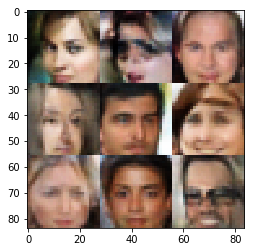

Epoch 4/10... Discriminator Loss: 0.4013... Generator Loss: 2.1661
Epoch 4/10... Discriminator Loss: 0.7900... Generator Loss: 1.9751
Epoch 4/10... Discriminator Loss: 0.8725... Generator Loss: 2.3040
Epoch 4/10... Discriminator Loss: 1.0362... Generator Loss: 0.6536
Epoch 4/10... Discriminator Loss: 0.8231... Generator Loss: 1.1817
Epoch 4/10... Discriminator Loss: 0.7594... Generator Loss: 3.6490
Epoch 4/10... Discriminator Loss: 0.5162... Generator Loss: 1.9514
Epoch 4/10... Discriminator Loss: 0.8405... Generator Loss: 2.7404
Epoch 4/10... Discriminator Loss: 1.0355... Generator Loss: 0.8534
Epoch 4/10... Discriminator Loss: 1.1800... Generator Loss: 0.6552


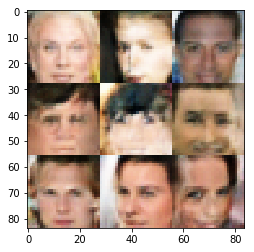

Epoch 4/10... Discriminator Loss: 0.6585... Generator Loss: 1.9434
Epoch 4/10... Discriminator Loss: 1.3202... Generator Loss: 0.4320
Epoch 5/10... Discriminator Loss: 0.4762... Generator Loss: 2.3286
Epoch 5/10... Discriminator Loss: 0.5768... Generator Loss: 1.1957
Epoch 5/10... Discriminator Loss: 0.4914... Generator Loss: 1.9039
Epoch 5/10... Discriminator Loss: 0.5031... Generator Loss: 2.5202
Epoch 5/10... Discriminator Loss: 0.8002... Generator Loss: 1.7782
Epoch 5/10... Discriminator Loss: 0.8353... Generator Loss: 1.3450
Epoch 5/10... Discriminator Loss: 0.6811... Generator Loss: 2.2930
Epoch 5/10... Discriminator Loss: 0.4505... Generator Loss: 2.9490


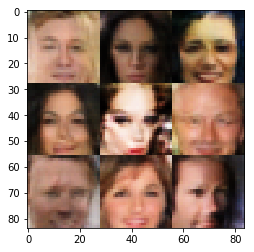

Epoch 5/10... Discriminator Loss: 0.8330... Generator Loss: 1.5825
Epoch 5/10... Discriminator Loss: 1.1479... Generator Loss: 0.5461
Epoch 5/10... Discriminator Loss: 1.0475... Generator Loss: 0.7114
Epoch 5/10... Discriminator Loss: 0.6413... Generator Loss: 1.4588
Epoch 5/10... Discriminator Loss: 0.6124... Generator Loss: 2.5700
Epoch 5/10... Discriminator Loss: 0.8554... Generator Loss: 4.0369
Epoch 5/10... Discriminator Loss: 1.0524... Generator Loss: 0.6564
Epoch 5/10... Discriminator Loss: 0.6113... Generator Loss: 1.8182
Epoch 5/10... Discriminator Loss: 0.3672... Generator Loss: 2.2408
Epoch 5/10... Discriminator Loss: 0.7407... Generator Loss: 1.2612


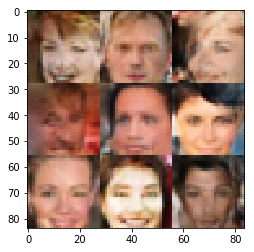

Epoch 5/10... Discriminator Loss: 1.1926... Generator Loss: 0.5430
Epoch 5/10... Discriminator Loss: 0.8369... Generator Loss: 0.7835
Epoch 5/10... Discriminator Loss: 0.9745... Generator Loss: 2.2214
Epoch 5/10... Discriminator Loss: 0.5975... Generator Loss: 1.1967
Epoch 5/10... Discriminator Loss: 0.5449... Generator Loss: 1.8600
Epoch 5/10... Discriminator Loss: 1.0608... Generator Loss: 0.5517
Epoch 5/10... Discriminator Loss: 0.6420... Generator Loss: 1.4574
Epoch 5/10... Discriminator Loss: 1.1203... Generator Loss: 0.5833
Epoch 5/10... Discriminator Loss: 0.5196... Generator Loss: 1.3004
Epoch 5/10... Discriminator Loss: 0.4211... Generator Loss: 2.2058


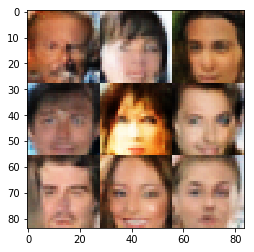

Epoch 5/10... Discriminator Loss: 0.7823... Generator Loss: 1.0376
Epoch 5/10... Discriminator Loss: 0.8889... Generator Loss: 0.8180
Epoch 5/10... Discriminator Loss: 1.3520... Generator Loss: 0.4140
Epoch 5/10... Discriminator Loss: 0.5279... Generator Loss: 2.1672
Epoch 5/10... Discriminator Loss: 0.7533... Generator Loss: 3.8113
Epoch 5/10... Discriminator Loss: 0.4641... Generator Loss: 2.7289
Epoch 5/10... Discriminator Loss: 0.5660... Generator Loss: 3.0159
Epoch 5/10... Discriminator Loss: 0.7854... Generator Loss: 0.9981
Epoch 5/10... Discriminator Loss: 0.8223... Generator Loss: 0.8888
Epoch 5/10... Discriminator Loss: 0.4319... Generator Loss: 2.9036


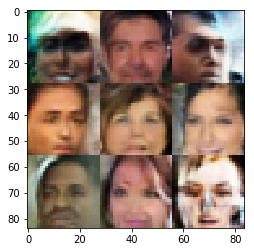

Epoch 5/10... Discriminator Loss: 1.0526... Generator Loss: 0.6028
Epoch 5/10... Discriminator Loss: 0.5498... Generator Loss: 1.8519
Epoch 5/10... Discriminator Loss: 0.7897... Generator Loss: 2.0671
Epoch 5/10... Discriminator Loss: 1.1269... Generator Loss: 0.5660
Epoch 5/10... Discriminator Loss: 0.6845... Generator Loss: 1.0560
Epoch 5/10... Discriminator Loss: 0.6175... Generator Loss: 1.3867
Epoch 5/10... Discriminator Loss: 0.6381... Generator Loss: 1.4185
Epoch 5/10... Discriminator Loss: 0.5336... Generator Loss: 1.7864
Epoch 5/10... Discriminator Loss: 0.7038... Generator Loss: 1.2021
Epoch 5/10... Discriminator Loss: 1.0407... Generator Loss: 2.4815


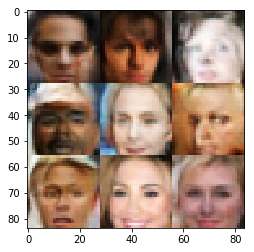

Epoch 5/10... Discriminator Loss: 0.4537... Generator Loss: 1.8644
Epoch 5/10... Discriminator Loss: 0.5652... Generator Loss: 3.2270
Epoch 5/10... Discriminator Loss: 0.5887... Generator Loss: 2.2052
Epoch 5/10... Discriminator Loss: 0.5070... Generator Loss: 1.6438
Epoch 5/10... Discriminator Loss: 0.8801... Generator Loss: 1.8791
Epoch 5/10... Discriminator Loss: 0.8905... Generator Loss: 1.0436
Epoch 5/10... Discriminator Loss: 1.0078... Generator Loss: 0.7518
Epoch 5/10... Discriminator Loss: 0.6761... Generator Loss: 1.8755
Epoch 5/10... Discriminator Loss: 0.4512... Generator Loss: 1.9293
Epoch 5/10... Discriminator Loss: 0.4656... Generator Loss: 2.2828


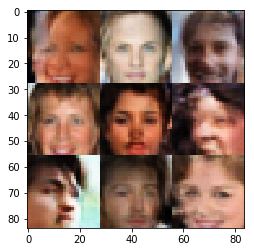

Epoch 5/10... Discriminator Loss: 0.7309... Generator Loss: 1.1244
Epoch 5/10... Discriminator Loss: 0.7292... Generator Loss: 0.9337
Epoch 5/10... Discriminator Loss: 0.8752... Generator Loss: 0.8540
Epoch 5/10... Discriminator Loss: 0.3605... Generator Loss: 2.1959
Epoch 5/10... Discriminator Loss: 0.7212... Generator Loss: 1.9051
Epoch 5/10... Discriminator Loss: 0.4742... Generator Loss: 2.0585
Epoch 5/10... Discriminator Loss: 0.8165... Generator Loss: 3.9837
Epoch 5/10... Discriminator Loss: 0.7700... Generator Loss: 1.0326
Epoch 5/10... Discriminator Loss: 1.4950... Generator Loss: 0.3743
Epoch 5/10... Discriminator Loss: 1.0239... Generator Loss: 0.5924


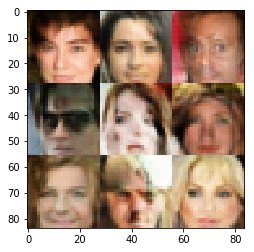

Epoch 5/10... Discriminator Loss: 0.5807... Generator Loss: 1.3776
Epoch 5/10... Discriminator Loss: 0.7380... Generator Loss: 1.3568
Epoch 5/10... Discriminator Loss: 0.7108... Generator Loss: 2.1149
Epoch 5/10... Discriminator Loss: 0.5333... Generator Loss: 1.8004
Epoch 5/10... Discriminator Loss: 0.7370... Generator Loss: 0.9961
Epoch 5/10... Discriminator Loss: 0.4825... Generator Loss: 1.5792
Epoch 5/10... Discriminator Loss: 0.7022... Generator Loss: 1.0728
Epoch 5/10... Discriminator Loss: 1.0703... Generator Loss: 2.8107
Epoch 5/10... Discriminator Loss: 1.0299... Generator Loss: 0.6235
Epoch 5/10... Discriminator Loss: 0.6470... Generator Loss: 2.0506


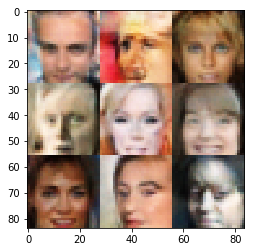

Epoch 5/10... Discriminator Loss: 0.9706... Generator Loss: 0.7134
Epoch 5/10... Discriminator Loss: 0.6814... Generator Loss: 2.5561
Epoch 5/10... Discriminator Loss: 1.1011... Generator Loss: 1.1885
Epoch 5/10... Discriminator Loss: 0.5859... Generator Loss: 1.2214
Epoch 5/10... Discriminator Loss: 0.6113... Generator Loss: 1.1144
Epoch 5/10... Discriminator Loss: 0.6256... Generator Loss: 1.8927
Epoch 5/10... Discriminator Loss: 0.9594... Generator Loss: 0.7372
Epoch 5/10... Discriminator Loss: 0.7179... Generator Loss: 1.7918
Epoch 5/10... Discriminator Loss: 0.6611... Generator Loss: 1.5639
Epoch 5/10... Discriminator Loss: 0.4605... Generator Loss: 2.3174


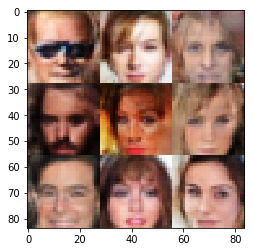

Epoch 5/10... Discriminator Loss: 0.7308... Generator Loss: 3.4424
Epoch 5/10... Discriminator Loss: 0.6228... Generator Loss: 2.5413
Epoch 5/10... Discriminator Loss: 0.9257... Generator Loss: 0.8376
Epoch 5/10... Discriminator Loss: 0.7105... Generator Loss: 0.9918
Epoch 5/10... Discriminator Loss: 0.5233... Generator Loss: 1.4177
Epoch 5/10... Discriminator Loss: 1.3344... Generator Loss: 0.4583
Epoch 5/10... Discriminator Loss: 0.9615... Generator Loss: 0.6802
Epoch 5/10... Discriminator Loss: 1.1182... Generator Loss: 0.6791
Epoch 5/10... Discriminator Loss: 0.7855... Generator Loss: 1.3800
Epoch 5/10... Discriminator Loss: 0.8493... Generator Loss: 1.8434


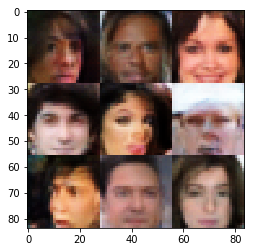

Epoch 5/10... Discriminator Loss: 0.4539... Generator Loss: 1.4429
Epoch 5/10... Discriminator Loss: 0.4177... Generator Loss: 2.3009
Epoch 5/10... Discriminator Loss: 1.5679... Generator Loss: 2.3471
Epoch 5/10... Discriminator Loss: 1.5364... Generator Loss: 1.2444
Epoch 5/10... Discriminator Loss: 1.3075... Generator Loss: 1.3835
Epoch 5/10... Discriminator Loss: 1.4103... Generator Loss: 0.4814
Epoch 5/10... Discriminator Loss: 0.9254... Generator Loss: 0.9715
Epoch 5/10... Discriminator Loss: 1.1152... Generator Loss: 1.8754
Epoch 5/10... Discriminator Loss: 0.9041... Generator Loss: 0.9839
Epoch 5/10... Discriminator Loss: 0.8003... Generator Loss: 1.0540


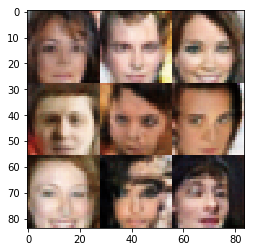

Epoch 5/10... Discriminator Loss: 0.9657... Generator Loss: 1.6721
Epoch 5/10... Discriminator Loss: 0.8068... Generator Loss: 1.6489
Epoch 5/10... Discriminator Loss: 0.9367... Generator Loss: 0.7971
Epoch 5/10... Discriminator Loss: 0.9625... Generator Loss: 1.0457
Epoch 5/10... Discriminator Loss: 0.8927... Generator Loss: 1.0331
Epoch 5/10... Discriminator Loss: 0.6998... Generator Loss: 1.2220
Epoch 5/10... Discriminator Loss: 0.9559... Generator Loss: 0.7303
Epoch 5/10... Discriminator Loss: 0.8405... Generator Loss: 1.2191
Epoch 5/10... Discriminator Loss: 0.9203... Generator Loss: 0.8606
Epoch 5/10... Discriminator Loss: 0.7808... Generator Loss: 1.1040


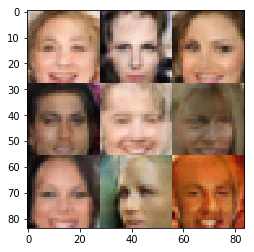

Epoch 5/10... Discriminator Loss: 0.8190... Generator Loss: 1.1742
Epoch 5/10... Discriminator Loss: 0.7848... Generator Loss: 1.5094
Epoch 5/10... Discriminator Loss: 0.8767... Generator Loss: 1.4159
Epoch 5/10... Discriminator Loss: 0.7800... Generator Loss: 1.3638
Epoch 5/10... Discriminator Loss: 1.0995... Generator Loss: 0.6559
Epoch 5/10... Discriminator Loss: 0.9706... Generator Loss: 1.3209
Epoch 5/10... Discriminator Loss: 0.8337... Generator Loss: 1.1278
Epoch 5/10... Discriminator Loss: 1.1675... Generator Loss: 0.6158
Epoch 5/10... Discriminator Loss: 1.0231... Generator Loss: 1.0167
Epoch 5/10... Discriminator Loss: 0.7714... Generator Loss: 1.4825


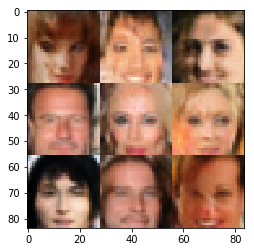

Epoch 5/10... Discriminator Loss: 0.7898... Generator Loss: 1.3865
Epoch 5/10... Discriminator Loss: 0.8509... Generator Loss: 0.8601
Epoch 5/10... Discriminator Loss: 0.7807... Generator Loss: 1.3423
Epoch 5/10... Discriminator Loss: 0.9587... Generator Loss: 0.9005
Epoch 5/10... Discriminator Loss: 0.8038... Generator Loss: 0.9630
Epoch 5/10... Discriminator Loss: 0.8358... Generator Loss: 1.1498
Epoch 5/10... Discriminator Loss: 0.8228... Generator Loss: 1.5394
Epoch 5/10... Discriminator Loss: 0.8068... Generator Loss: 1.3949
Epoch 5/10... Discriminator Loss: 0.8539... Generator Loss: 1.3835
Epoch 5/10... Discriminator Loss: 0.8358... Generator Loss: 1.1422


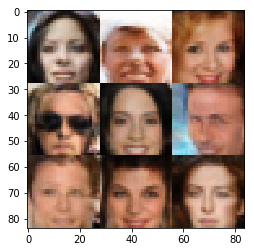

Epoch 5/10... Discriminator Loss: 0.9429... Generator Loss: 0.9630
Epoch 5/10... Discriminator Loss: 0.8592... Generator Loss: 1.0241
Epoch 5/10... Discriminator Loss: 0.9831... Generator Loss: 0.8404
Epoch 5/10... Discriminator Loss: 0.8183... Generator Loss: 1.1334
Epoch 5/10... Discriminator Loss: 1.1286... Generator Loss: 0.6559
Epoch 5/10... Discriminator Loss: 0.9489... Generator Loss: 1.5578
Epoch 5/10... Discriminator Loss: 0.8306... Generator Loss: 1.0431
Epoch 5/10... Discriminator Loss: 0.9741... Generator Loss: 0.7900
Epoch 5/10... Discriminator Loss: 0.9159... Generator Loss: 0.7857
Epoch 5/10... Discriminator Loss: 0.8584... Generator Loss: 1.0163


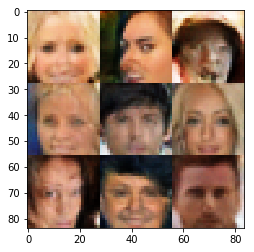

Epoch 5/10... Discriminator Loss: 1.1321... Generator Loss: 0.6916
Epoch 5/10... Discriminator Loss: 1.0107... Generator Loss: 0.7478
Epoch 5/10... Discriminator Loss: 0.9465... Generator Loss: 0.7777
Epoch 5/10... Discriminator Loss: 0.8667... Generator Loss: 1.1428
Epoch 5/10... Discriminator Loss: 0.9151... Generator Loss: 0.8239
Epoch 5/10... Discriminator Loss: 0.9755... Generator Loss: 0.8726
Epoch 5/10... Discriminator Loss: 0.9699... Generator Loss: 0.7727
Epoch 5/10... Discriminator Loss: 0.9451... Generator Loss: 0.8926
Epoch 5/10... Discriminator Loss: 0.9445... Generator Loss: 1.1072
Epoch 5/10... Discriminator Loss: 1.0346... Generator Loss: 0.8864


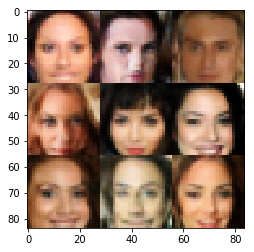

Epoch 5/10... Discriminator Loss: 0.9985... Generator Loss: 0.9787
Epoch 6/10... Discriminator Loss: 0.8784... Generator Loss: 1.4497
Epoch 6/10... Discriminator Loss: 0.8347... Generator Loss: 1.0343
Epoch 6/10... Discriminator Loss: 0.8781... Generator Loss: 1.0436
Epoch 6/10... Discriminator Loss: 0.9368... Generator Loss: 0.8487
Epoch 6/10... Discriminator Loss: 0.9292... Generator Loss: 0.8047
Epoch 6/10... Discriminator Loss: 1.0413... Generator Loss: 0.6655
Epoch 6/10... Discriminator Loss: 0.8823... Generator Loss: 1.2148
Epoch 6/10... Discriminator Loss: 0.8848... Generator Loss: 1.1555
Epoch 6/10... Discriminator Loss: 1.1185... Generator Loss: 0.6818


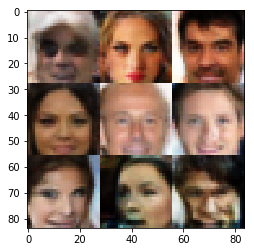

Epoch 6/10... Discriminator Loss: 0.8882... Generator Loss: 1.5361
Epoch 6/10... Discriminator Loss: 0.8449... Generator Loss: 1.0980
Epoch 6/10... Discriminator Loss: 1.0184... Generator Loss: 0.9918
Epoch 6/10... Discriminator Loss: 0.8944... Generator Loss: 1.1278
Epoch 6/10... Discriminator Loss: 0.9179... Generator Loss: 1.0878
Epoch 6/10... Discriminator Loss: 1.0302... Generator Loss: 0.7084
Epoch 6/10... Discriminator Loss: 0.8527... Generator Loss: 1.2996
Epoch 6/10... Discriminator Loss: 0.8740... Generator Loss: 0.9908
Epoch 6/10... Discriminator Loss: 1.0556... Generator Loss: 0.7321
Epoch 6/10... Discriminator Loss: 0.9663... Generator Loss: 1.2790


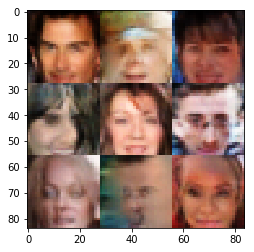

Epoch 6/10... Discriminator Loss: 0.8134... Generator Loss: 1.5067
Epoch 6/10... Discriminator Loss: 1.1466... Generator Loss: 0.6022
Epoch 6/10... Discriminator Loss: 0.8376... Generator Loss: 1.0830
Epoch 6/10... Discriminator Loss: 1.0662... Generator Loss: 0.7828
Epoch 6/10... Discriminator Loss: 0.9768... Generator Loss: 0.9083
Epoch 6/10... Discriminator Loss: 0.8928... Generator Loss: 1.2007
Epoch 6/10... Discriminator Loss: 0.9272... Generator Loss: 1.3337
Epoch 6/10... Discriminator Loss: 0.8536... Generator Loss: 1.4584
Epoch 6/10... Discriminator Loss: 0.8782... Generator Loss: 1.9454
Epoch 6/10... Discriminator Loss: 0.9388... Generator Loss: 0.9181


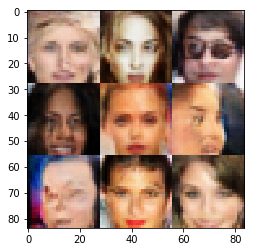

Epoch 6/10... Discriminator Loss: 1.2021... Generator Loss: 0.5755
Epoch 6/10... Discriminator Loss: 0.9755... Generator Loss: 0.8523
Epoch 6/10... Discriminator Loss: 0.8346... Generator Loss: 1.4315
Epoch 6/10... Discriminator Loss: 0.9247... Generator Loss: 1.6904
Epoch 6/10... Discriminator Loss: 0.9240... Generator Loss: 1.3187
Epoch 6/10... Discriminator Loss: 0.9072... Generator Loss: 1.0707
Epoch 6/10... Discriminator Loss: 0.9513... Generator Loss: 0.7588
Epoch 6/10... Discriminator Loss: 1.0643... Generator Loss: 1.8095
Epoch 6/10... Discriminator Loss: 0.9029... Generator Loss: 0.9625
Epoch 6/10... Discriminator Loss: 0.8453... Generator Loss: 1.3641


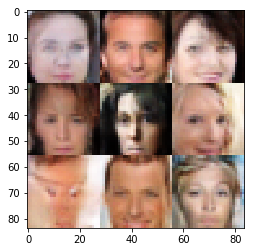

Epoch 6/10... Discriminator Loss: 0.9723... Generator Loss: 1.4229
Epoch 6/10... Discriminator Loss: 1.2109... Generator Loss: 1.8889
Epoch 6/10... Discriminator Loss: 0.9925... Generator Loss: 0.7795
Epoch 6/10... Discriminator Loss: 0.8429... Generator Loss: 1.2378
Epoch 6/10... Discriminator Loss: 0.8939... Generator Loss: 0.9017
Epoch 6/10... Discriminator Loss: 1.0888... Generator Loss: 0.6503
Epoch 6/10... Discriminator Loss: 1.1780... Generator Loss: 0.9599
Epoch 6/10... Discriminator Loss: 1.0332... Generator Loss: 1.5308
Epoch 6/10... Discriminator Loss: 0.9328... Generator Loss: 1.1680
Epoch 6/10... Discriminator Loss: 0.9035... Generator Loss: 1.0559


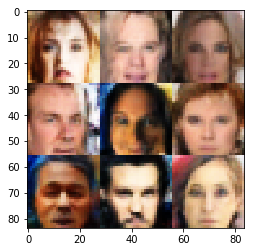

Epoch 6/10... Discriminator Loss: 0.9843... Generator Loss: 1.0271
Epoch 6/10... Discriminator Loss: 0.9683... Generator Loss: 1.6871
Epoch 6/10... Discriminator Loss: 0.9090... Generator Loss: 1.1215
Epoch 6/10... Discriminator Loss: 0.8836... Generator Loss: 1.5787
Epoch 6/10... Discriminator Loss: 1.0557... Generator Loss: 0.6582
Epoch 6/10... Discriminator Loss: 1.1108... Generator Loss: 1.1764
Epoch 6/10... Discriminator Loss: 0.8614... Generator Loss: 1.3080
Epoch 6/10... Discriminator Loss: 0.9869... Generator Loss: 0.7976
Epoch 6/10... Discriminator Loss: 1.0723... Generator Loss: 0.8033
Epoch 6/10... Discriminator Loss: 0.9897... Generator Loss: 0.8138


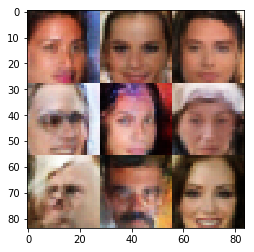

Epoch 6/10... Discriminator Loss: 1.0347... Generator Loss: 0.8314
Epoch 6/10... Discriminator Loss: 1.1688... Generator Loss: 0.5679
Epoch 6/10... Discriminator Loss: 1.1095... Generator Loss: 1.6149
Epoch 6/10... Discriminator Loss: 0.9536... Generator Loss: 1.3172
Epoch 6/10... Discriminator Loss: 0.8964... Generator Loss: 0.9773
Epoch 6/10... Discriminator Loss: 0.8117... Generator Loss: 1.3209
Epoch 6/10... Discriminator Loss: 1.0074... Generator Loss: 0.8707
Epoch 6/10... Discriminator Loss: 1.0393... Generator Loss: 0.7544
Epoch 6/10... Discriminator Loss: 0.8565... Generator Loss: 1.3781
Epoch 6/10... Discriminator Loss: 0.9509... Generator Loss: 0.9390
Epoch 6/10... Discriminator Loss: 1.0751... Generator Loss: 0.7747
Epoch 6/10... Discriminator Loss: 0.8772... Generator Loss: 1.1036
Epoch 6/10... Discriminator Loss: 1.1154... Generator Loss: 1.1452
Epoch 6/10... Discriminator Loss: 0.9873... Generator Loss: 0.8806
Epoch 6/10... Discriminator Loss: 1.0688... Generator Loss: 0.

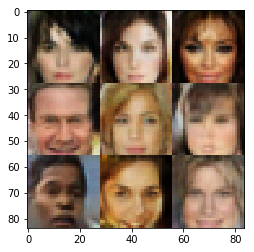

Epoch 6/10... Discriminator Loss: 0.9897... Generator Loss: 0.7904
Epoch 6/10... Discriminator Loss: 0.9595... Generator Loss: 0.9157
Epoch 6/10... Discriminator Loss: 1.2344... Generator Loss: 1.7749
Epoch 6/10... Discriminator Loss: 1.2386... Generator Loss: 1.2341
Epoch 6/10... Discriminator Loss: 1.0225... Generator Loss: 1.3585
Epoch 6/10... Discriminator Loss: 1.0187... Generator Loss: 0.7989
Epoch 6/10... Discriminator Loss: 1.0516... Generator Loss: 1.1861
Epoch 6/10... Discriminator Loss: 0.9908... Generator Loss: 0.8687
Epoch 6/10... Discriminator Loss: 0.9648... Generator Loss: 0.9762
Epoch 6/10... Discriminator Loss: 1.0083... Generator Loss: 0.7088


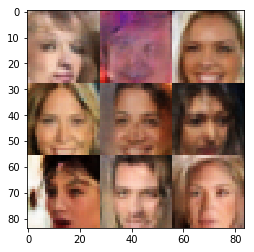

Epoch 6/10... Discriminator Loss: 1.2079... Generator Loss: 1.0192
Epoch 6/10... Discriminator Loss: 1.1294... Generator Loss: 1.3259
Epoch 6/10... Discriminator Loss: 1.0431... Generator Loss: 0.7740
Epoch 6/10... Discriminator Loss: 1.0053... Generator Loss: 0.7572
Epoch 6/10... Discriminator Loss: 1.0154... Generator Loss: 0.8650
Epoch 6/10... Discriminator Loss: 1.0515... Generator Loss: 0.8377
Epoch 6/10... Discriminator Loss: 0.8413... Generator Loss: 1.2185
Epoch 6/10... Discriminator Loss: 1.0895... Generator Loss: 1.2536
Epoch 6/10... Discriminator Loss: 1.1523... Generator Loss: 1.1259
Epoch 6/10... Discriminator Loss: 0.9943... Generator Loss: 0.7621


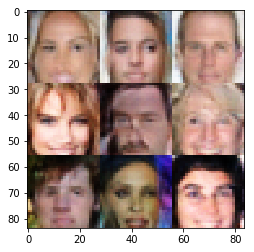

Epoch 6/10... Discriminator Loss: 0.9429... Generator Loss: 1.1533
Epoch 6/10... Discriminator Loss: 1.0666... Generator Loss: 0.7465
Epoch 6/10... Discriminator Loss: 0.9468... Generator Loss: 1.0497
Epoch 6/10... Discriminator Loss: 1.0834... Generator Loss: 1.8228
Epoch 6/10... Discriminator Loss: 0.8571... Generator Loss: 0.9442
Epoch 6/10... Discriminator Loss: 0.8969... Generator Loss: 1.0796
Epoch 6/10... Discriminator Loss: 1.2068... Generator Loss: 0.5458
Epoch 6/10... Discriminator Loss: 0.6667... Generator Loss: 1.1492
Epoch 6/10... Discriminator Loss: 0.6887... Generator Loss: 1.1575
Epoch 6/10... Discriminator Loss: 0.8397... Generator Loss: 0.9398


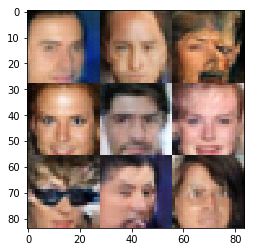

Epoch 6/10... Discriminator Loss: 1.4847... Generator Loss: 0.9756
Epoch 6/10... Discriminator Loss: 1.2817... Generator Loss: 0.8236
Epoch 6/10... Discriminator Loss: 1.1903... Generator Loss: 0.6290
Epoch 6/10... Discriminator Loss: 1.1415... Generator Loss: 0.8677
Epoch 6/10... Discriminator Loss: 1.1652... Generator Loss: 0.8580
Epoch 6/10... Discriminator Loss: 1.0643... Generator Loss: 0.9237
Epoch 6/10... Discriminator Loss: 0.9640... Generator Loss: 2.2696
Epoch 6/10... Discriminator Loss: 0.7799... Generator Loss: 1.1164
Epoch 6/10... Discriminator Loss: 0.8694... Generator Loss: 1.6327
Epoch 6/10... Discriminator Loss: 1.2175... Generator Loss: 0.4719


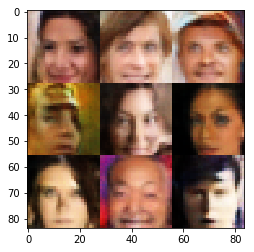

Epoch 6/10... Discriminator Loss: 0.4584... Generator Loss: 2.3734
Epoch 6/10... Discriminator Loss: 0.4049... Generator Loss: 1.3224
Epoch 6/10... Discriminator Loss: 0.8393... Generator Loss: 1.7248
Epoch 6/10... Discriminator Loss: 0.6471... Generator Loss: 1.0135
Epoch 6/10... Discriminator Loss: 1.1961... Generator Loss: 0.5730
Epoch 6/10... Discriminator Loss: 0.3992... Generator Loss: 2.6877
Epoch 6/10... Discriminator Loss: 0.8048... Generator Loss: 0.8032
Epoch 6/10... Discriminator Loss: 0.9728... Generator Loss: 2.5494
Epoch 6/10... Discriminator Loss: 0.3111... Generator Loss: 3.7493
Epoch 6/10... Discriminator Loss: 2.3533... Generator Loss: 3.0462


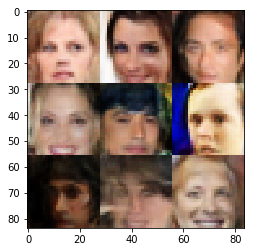

Epoch 6/10... Discriminator Loss: 0.2198... Generator Loss: 3.1095
Epoch 6/10... Discriminator Loss: 1.0849... Generator Loss: 0.5934
Epoch 6/10... Discriminator Loss: 0.3933... Generator Loss: 4.3657
Epoch 6/10... Discriminator Loss: 0.5713... Generator Loss: 0.9894
Epoch 6/10... Discriminator Loss: 1.9045... Generator Loss: 1.8050
Epoch 6/10... Discriminator Loss: 0.2758... Generator Loss: 3.9561
Epoch 6/10... Discriminator Loss: 0.2705... Generator Loss: 2.9696
Epoch 6/10... Discriminator Loss: 1.9431... Generator Loss: 1.9400
Epoch 6/10... Discriminator Loss: 1.0899... Generator Loss: 1.7539
Epoch 6/10... Discriminator Loss: 0.8997... Generator Loss: 1.0395


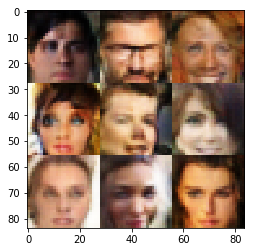

Epoch 6/10... Discriminator Loss: 0.8951... Generator Loss: 0.9936
Epoch 6/10... Discriminator Loss: 1.0784... Generator Loss: 0.5932
Epoch 6/10... Discriminator Loss: 0.7889... Generator Loss: 1.2518
Epoch 6/10... Discriminator Loss: 0.8705... Generator Loss: 1.1044
Epoch 6/10... Discriminator Loss: 0.9234... Generator Loss: 1.3831
Epoch 6/10... Discriminator Loss: 1.1061... Generator Loss: 0.5969
Epoch 6/10... Discriminator Loss: 1.0692... Generator Loss: 0.7145
Epoch 6/10... Discriminator Loss: 0.9584... Generator Loss: 0.8956
Epoch 6/10... Discriminator Loss: 1.0462... Generator Loss: 0.7120
Epoch 6/10... Discriminator Loss: 1.0430... Generator Loss: 0.8467


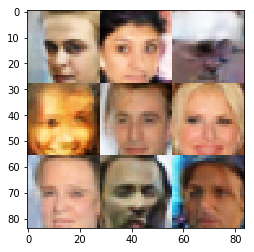

Epoch 6/10... Discriminator Loss: 0.9119... Generator Loss: 1.1954
Epoch 6/10... Discriminator Loss: 0.9575... Generator Loss: 1.1647
Epoch 6/10... Discriminator Loss: 1.0482... Generator Loss: 0.8737
Epoch 6/10... Discriminator Loss: 0.9361... Generator Loss: 1.0926
Epoch 6/10... Discriminator Loss: 1.2495... Generator Loss: 0.4710
Epoch 6/10... Discriminator Loss: 0.9612... Generator Loss: 1.5914
Epoch 6/10... Discriminator Loss: 1.0279... Generator Loss: 0.9277
Epoch 6/10... Discriminator Loss: 1.1732... Generator Loss: 0.5894
Epoch 6/10... Discriminator Loss: 1.0429... Generator Loss: 0.8988
Epoch 7/10... Discriminator Loss: 1.1707... Generator Loss: 2.0084


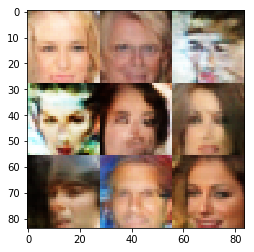

Epoch 7/10... Discriminator Loss: 0.9801... Generator Loss: 0.9399
Epoch 7/10... Discriminator Loss: 0.9205... Generator Loss: 1.2945
Epoch 7/10... Discriminator Loss: 1.1350... Generator Loss: 0.6813
Epoch 7/10... Discriminator Loss: 0.9256... Generator Loss: 1.0985
Epoch 7/10... Discriminator Loss: 0.9242... Generator Loss: 1.0364
Epoch 7/10... Discriminator Loss: 0.9695... Generator Loss: 0.8170
Epoch 7/10... Discriminator Loss: 1.1595... Generator Loss: 0.6009
Epoch 7/10... Discriminator Loss: 0.9931... Generator Loss: 0.9015
Epoch 7/10... Discriminator Loss: 1.0594... Generator Loss: 1.1007
Epoch 7/10... Discriminator Loss: 1.0880... Generator Loss: 0.6267


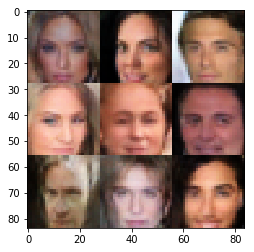

Epoch 7/10... Discriminator Loss: 1.1324... Generator Loss: 0.8355
Epoch 7/10... Discriminator Loss: 1.1012... Generator Loss: 0.7170
Epoch 7/10... Discriminator Loss: 1.1585... Generator Loss: 1.2359
Epoch 7/10... Discriminator Loss: 1.0535... Generator Loss: 0.7339
Epoch 7/10... Discriminator Loss: 1.0325... Generator Loss: 0.7088
Epoch 7/10... Discriminator Loss: 0.9424... Generator Loss: 0.9548
Epoch 7/10... Discriminator Loss: 1.1861... Generator Loss: 0.8168
Epoch 7/10... Discriminator Loss: 1.1512... Generator Loss: 1.0263
Epoch 7/10... Discriminator Loss: 1.0339... Generator Loss: 0.7191
Epoch 7/10... Discriminator Loss: 1.0802... Generator Loss: 0.8429
Epoch 7/10... Discriminator Loss: 0.9652... Generator Loss: 0.9339
Epoch 7/10... Discriminator Loss: 1.3185... Generator Loss: 0.4487
Epoch 7/10... Discriminator Loss: 1.0669... Generator Loss: 0.9447
Epoch 7/10... Discriminator Loss: 1.0822... Generator Loss: 0.7447
Epoch 7/10... Discriminator Loss: 1.2613... Generator Loss: 0.

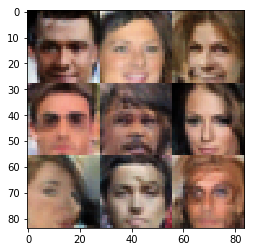

Epoch 7/10... Discriminator Loss: 1.0105... Generator Loss: 0.8220
Epoch 7/10... Discriminator Loss: 1.0961... Generator Loss: 0.8331
Epoch 7/10... Discriminator Loss: 1.1372... Generator Loss: 1.1934
Epoch 7/10... Discriminator Loss: 1.0500... Generator Loss: 0.7417
Epoch 7/10... Discriminator Loss: 0.9990... Generator Loss: 0.8952
Epoch 7/10... Discriminator Loss: 1.0810... Generator Loss: 0.9019
Epoch 7/10... Discriminator Loss: 1.0806... Generator Loss: 0.7083
Epoch 7/10... Discriminator Loss: 1.2493... Generator Loss: 0.4934
Epoch 7/10... Discriminator Loss: 0.8664... Generator Loss: 0.9247
Epoch 7/10... Discriminator Loss: 0.9889... Generator Loss: 0.7247


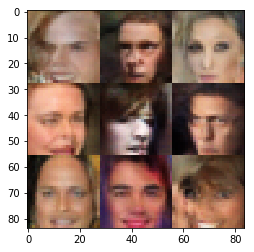

Epoch 7/10... Discriminator Loss: 1.4288... Generator Loss: 0.3872
Epoch 7/10... Discriminator Loss: 1.1488... Generator Loss: 0.8335
Epoch 7/10... Discriminator Loss: 0.8408... Generator Loss: 1.3115
Epoch 7/10... Discriminator Loss: 0.8479... Generator Loss: 1.3142
Epoch 7/10... Discriminator Loss: 1.0205... Generator Loss: 0.6679
Epoch 7/10... Discriminator Loss: 1.3179... Generator Loss: 0.5997
Epoch 7/10... Discriminator Loss: 0.5322... Generator Loss: 1.3001
Epoch 7/10... Discriminator Loss: 0.7738... Generator Loss: 3.1026
Epoch 7/10... Discriminator Loss: 0.9457... Generator Loss: 5.1697
Epoch 7/10... Discriminator Loss: 0.4820... Generator Loss: 5.1503


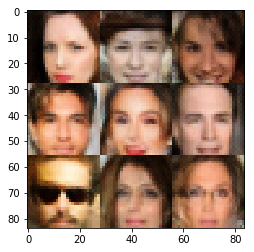

Epoch 7/10... Discriminator Loss: 0.6477... Generator Loss: 0.9049
Epoch 7/10... Discriminator Loss: 0.2345... Generator Loss: 2.7715
Epoch 7/10... Discriminator Loss: 1.8332... Generator Loss: 0.2320
Epoch 7/10... Discriminator Loss: 0.4158... Generator Loss: 5.1238
Epoch 7/10... Discriminator Loss: 0.3830... Generator Loss: 1.5684
Epoch 7/10... Discriminator Loss: 1.4170... Generator Loss: 5.3106
Epoch 7/10... Discriminator Loss: 0.8307... Generator Loss: 1.4406
Epoch 7/10... Discriminator Loss: 0.3672... Generator Loss: 2.9620
Epoch 7/10... Discriminator Loss: 0.7474... Generator Loss: 1.4103
Epoch 7/10... Discriminator Loss: 0.4148... Generator Loss: 1.4606


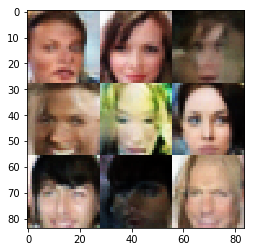

Epoch 7/10... Discriminator Loss: 0.3295... Generator Loss: 4.4884
Epoch 7/10... Discriminator Loss: 0.3985... Generator Loss: 3.5428
Epoch 7/10... Discriminator Loss: 0.1750... Generator Loss: 3.2191
Epoch 7/10... Discriminator Loss: 1.3589... Generator Loss: 0.3907
Epoch 7/10... Discriminator Loss: 0.2013... Generator Loss: 2.2785
Epoch 7/10... Discriminator Loss: 1.1114... Generator Loss: 0.5373
Epoch 7/10... Discriminator Loss: 0.6711... Generator Loss: 0.9689
Epoch 7/10... Discriminator Loss: 0.3127... Generator Loss: 5.3542
Epoch 7/10... Discriminator Loss: 1.9380... Generator Loss: 0.2124
Epoch 7/10... Discriminator Loss: 0.4692... Generator Loss: 1.2559


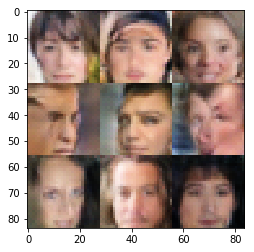

Epoch 7/10... Discriminator Loss: 0.7331... Generator Loss: 0.8770
Epoch 7/10... Discriminator Loss: 1.2046... Generator Loss: 0.4714
Epoch 7/10... Discriminator Loss: 0.5208... Generator Loss: 1.3452
Epoch 7/10... Discriminator Loss: 0.9064... Generator Loss: 0.7666
Epoch 7/10... Discriminator Loss: 0.9541... Generator Loss: 4.9483
Epoch 7/10... Discriminator Loss: 0.2427... Generator Loss: 2.1568
Epoch 7/10... Discriminator Loss: 0.8903... Generator Loss: 0.7581
Epoch 7/10... Discriminator Loss: 1.2416... Generator Loss: 3.9674
Epoch 7/10... Discriminator Loss: 0.4321... Generator Loss: 1.7395
Epoch 7/10... Discriminator Loss: 0.2080... Generator Loss: 2.6659


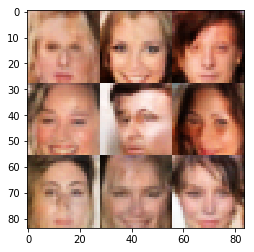

Epoch 7/10... Discriminator Loss: 0.8654... Generator Loss: 5.1811
Epoch 7/10... Discriminator Loss: 1.3637... Generator Loss: 3.3906
Epoch 7/10... Discriminator Loss: 0.6531... Generator Loss: 2.6661
Epoch 7/10... Discriminator Loss: 0.4697... Generator Loss: 1.9633
Epoch 7/10... Discriminator Loss: 0.5829... Generator Loss: 3.1798
Epoch 7/10... Discriminator Loss: 0.6623... Generator Loss: 1.8557
Epoch 7/10... Discriminator Loss: 0.5409... Generator Loss: 3.0388
Epoch 7/10... Discriminator Loss: 0.4273... Generator Loss: 2.2113
Epoch 7/10... Discriminator Loss: 0.9870... Generator Loss: 0.7019
Epoch 7/10... Discriminator Loss: 0.9988... Generator Loss: 1.2879


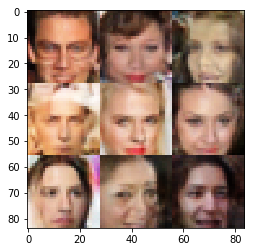

Epoch 7/10... Discriminator Loss: 0.5372... Generator Loss: 1.6504
Epoch 7/10... Discriminator Loss: 0.2323... Generator Loss: 3.2560
Epoch 7/10... Discriminator Loss: 0.4446... Generator Loss: 3.4377
Epoch 7/10... Discriminator Loss: 1.3106... Generator Loss: 4.2129
Epoch 7/10... Discriminator Loss: 0.4682... Generator Loss: 1.4198
Epoch 7/10... Discriminator Loss: 1.5792... Generator Loss: 0.3210
Epoch 7/10... Discriminator Loss: 0.2393... Generator Loss: 2.4793
Epoch 7/10... Discriminator Loss: 0.4302... Generator Loss: 3.9526
Epoch 7/10... Discriminator Loss: 0.3220... Generator Loss: 2.3206
Epoch 7/10... Discriminator Loss: 0.7235... Generator Loss: 0.9307


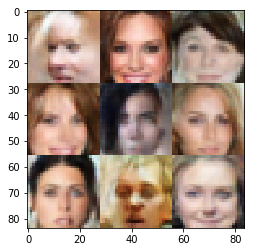

Epoch 7/10... Discriminator Loss: 0.9620... Generator Loss: 0.8891
Epoch 7/10... Discriminator Loss: 1.1802... Generator Loss: 1.0634
Epoch 7/10... Discriminator Loss: 1.1100... Generator Loss: 0.6778
Epoch 7/10... Discriminator Loss: 0.9046... Generator Loss: 0.8000
Epoch 7/10... Discriminator Loss: 0.7578... Generator Loss: 1.4416
Epoch 7/10... Discriminator Loss: 0.6794... Generator Loss: 1.6523
Epoch 7/10... Discriminator Loss: 0.7294... Generator Loss: 1.3055
Epoch 7/10... Discriminator Loss: 0.8790... Generator Loss: 1.0716
Epoch 7/10... Discriminator Loss: 0.7782... Generator Loss: 0.9428
Epoch 7/10... Discriminator Loss: 0.9387... Generator Loss: 0.9659


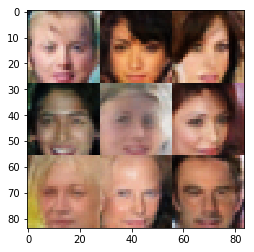

Epoch 7/10... Discriminator Loss: 0.8061... Generator Loss: 0.9353
Epoch 7/10... Discriminator Loss: 1.1718... Generator Loss: 0.8266
Epoch 7/10... Discriminator Loss: 0.7108... Generator Loss: 1.3707
Epoch 7/10... Discriminator Loss: 1.1775... Generator Loss: 1.9141
Epoch 7/10... Discriminator Loss: 0.8101... Generator Loss: 1.0288
Epoch 7/10... Discriminator Loss: 0.7416... Generator Loss: 1.1596
Epoch 7/10... Discriminator Loss: 0.9518... Generator Loss: 1.0398
Epoch 7/10... Discriminator Loss: 0.9627... Generator Loss: 0.7310
Epoch 7/10... Discriminator Loss: 0.7926... Generator Loss: 1.3066
Epoch 7/10... Discriminator Loss: 0.7561... Generator Loss: 1.3492


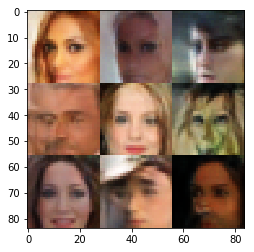

Epoch 7/10... Discriminator Loss: 0.9742... Generator Loss: 1.0157
Epoch 7/10... Discriminator Loss: 0.8579... Generator Loss: 0.9316
Epoch 7/10... Discriminator Loss: 1.0872... Generator Loss: 0.7493
Epoch 7/10... Discriminator Loss: 0.9181... Generator Loss: 0.7211
Epoch 7/10... Discriminator Loss: 0.9385... Generator Loss: 0.8042
Epoch 7/10... Discriminator Loss: 0.9391... Generator Loss: 0.8626
Epoch 7/10... Discriminator Loss: 0.8009... Generator Loss: 1.2461
Epoch 8/10... Discriminator Loss: 0.9785... Generator Loss: 1.1746
Epoch 8/10... Discriminator Loss: 0.9636... Generator Loss: 1.2453
Epoch 8/10... Discriminator Loss: 1.0916... Generator Loss: 0.6486


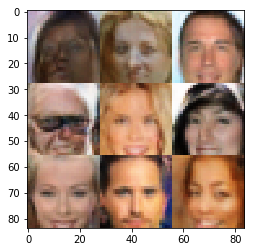

Epoch 8/10... Discriminator Loss: 0.8445... Generator Loss: 0.8438
Epoch 8/10... Discriminator Loss: 0.8487... Generator Loss: 1.0469
Epoch 8/10... Discriminator Loss: 1.0691... Generator Loss: 0.6393
Epoch 8/10... Discriminator Loss: 0.9581... Generator Loss: 0.9218
Epoch 8/10... Discriminator Loss: 0.8098... Generator Loss: 1.1792
Epoch 8/10... Discriminator Loss: 0.8914... Generator Loss: 1.1436
Epoch 8/10... Discriminator Loss: 0.8307... Generator Loss: 1.2182
Epoch 8/10... Discriminator Loss: 0.8738... Generator Loss: 1.3243
Epoch 8/10... Discriminator Loss: 0.7740... Generator Loss: 1.2902
Epoch 8/10... Discriminator Loss: 0.9391... Generator Loss: 1.3117


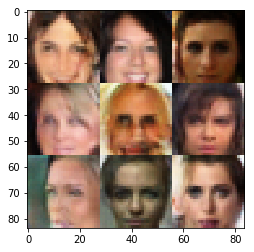

Epoch 8/10... Discriminator Loss: 1.0040... Generator Loss: 0.8072
Epoch 8/10... Discriminator Loss: 0.8095... Generator Loss: 1.3025
Epoch 8/10... Discriminator Loss: 0.8525... Generator Loss: 1.0182
Epoch 8/10... Discriminator Loss: 1.1343... Generator Loss: 0.6370
Epoch 8/10... Discriminator Loss: 0.8592... Generator Loss: 1.4307
Epoch 8/10... Discriminator Loss: 0.7984... Generator Loss: 1.2616
Epoch 8/10... Discriminator Loss: 1.0233... Generator Loss: 0.6953
Epoch 8/10... Discriminator Loss: 1.1055... Generator Loss: 1.1869
Epoch 8/10... Discriminator Loss: 0.8912... Generator Loss: 1.2752
Epoch 8/10... Discriminator Loss: 1.0064... Generator Loss: 0.7765


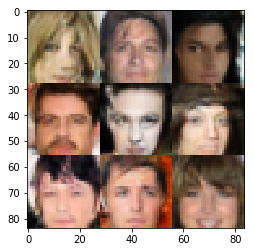

Epoch 8/10... Discriminator Loss: 1.0131... Generator Loss: 0.9940
Epoch 8/10... Discriminator Loss: 0.9621... Generator Loss: 0.7211
Epoch 8/10... Discriminator Loss: 0.9453... Generator Loss: 0.8064
Epoch 8/10... Discriminator Loss: 0.9237... Generator Loss: 1.2887
Epoch 8/10... Discriminator Loss: 0.8599... Generator Loss: 1.1534
Epoch 8/10... Discriminator Loss: 0.8334... Generator Loss: 1.0397
Epoch 8/10... Discriminator Loss: 1.0544... Generator Loss: 0.8567
Epoch 8/10... Discriminator Loss: 0.9954... Generator Loss: 1.3156
Epoch 8/10... Discriminator Loss: 0.8738... Generator Loss: 0.9828
Epoch 8/10... Discriminator Loss: 0.9606... Generator Loss: 0.8584


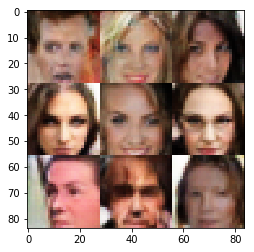

Epoch 8/10... Discriminator Loss: 0.8707... Generator Loss: 1.1364
Epoch 8/10... Discriminator Loss: 0.9592... Generator Loss: 1.2316
Epoch 8/10... Discriminator Loss: 0.8436... Generator Loss: 1.2179
Epoch 8/10... Discriminator Loss: 0.8202... Generator Loss: 0.8787
Epoch 8/10... Discriminator Loss: 1.0415... Generator Loss: 0.9998
Epoch 8/10... Discriminator Loss: 1.1496... Generator Loss: 1.4975
Epoch 8/10... Discriminator Loss: 0.9999... Generator Loss: 0.8491
Epoch 8/10... Discriminator Loss: 1.1085... Generator Loss: 0.9157
Epoch 8/10... Discriminator Loss: 1.1082... Generator Loss: 0.5998
Epoch 8/10... Discriminator Loss: 1.0020... Generator Loss: 0.7168


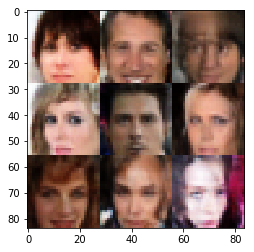

Epoch 8/10... Discriminator Loss: 0.8242... Generator Loss: 1.0833
Epoch 8/10... Discriminator Loss: 0.9312... Generator Loss: 0.9704
Epoch 8/10... Discriminator Loss: 0.9372... Generator Loss: 1.0448
Epoch 8/10... Discriminator Loss: 0.9109... Generator Loss: 1.1928
Epoch 8/10... Discriminator Loss: 1.1802... Generator Loss: 0.5437
Epoch 8/10... Discriminator Loss: 1.0882... Generator Loss: 0.6563
Epoch 8/10... Discriminator Loss: 0.8905... Generator Loss: 1.1866
Epoch 8/10... Discriminator Loss: 0.9543... Generator Loss: 0.9805
Epoch 8/10... Discriminator Loss: 0.8507... Generator Loss: 0.9202
Epoch 8/10... Discriminator Loss: 1.2302... Generator Loss: 0.5084


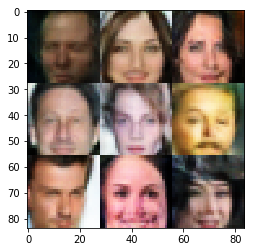

Epoch 8/10... Discriminator Loss: 1.0531... Generator Loss: 1.2988
Epoch 8/10... Discriminator Loss: 0.9673... Generator Loss: 1.0124
Epoch 8/10... Discriminator Loss: 1.0502... Generator Loss: 0.7235
Epoch 8/10... Discriminator Loss: 0.8843... Generator Loss: 1.1412
Epoch 8/10... Discriminator Loss: 1.0397... Generator Loss: 1.2973
Epoch 8/10... Discriminator Loss: 0.9110... Generator Loss: 1.0763
Epoch 8/10... Discriminator Loss: 0.9778... Generator Loss: 0.7465
Epoch 8/10... Discriminator Loss: 0.9508... Generator Loss: 1.0186
Epoch 8/10... Discriminator Loss: 1.0636... Generator Loss: 0.6187
Epoch 8/10... Discriminator Loss: 1.0136... Generator Loss: 1.0172


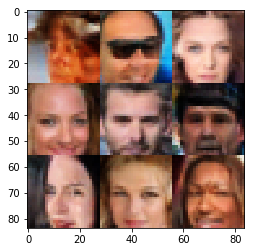

Epoch 8/10... Discriminator Loss: 0.9364... Generator Loss: 0.8239
Epoch 8/10... Discriminator Loss: 1.1873... Generator Loss: 0.6043
Epoch 8/10... Discriminator Loss: 1.0462... Generator Loss: 0.9053
Epoch 8/10... Discriminator Loss: 1.0055... Generator Loss: 1.4781
Epoch 8/10... Discriminator Loss: 0.9861... Generator Loss: 1.2970
Epoch 8/10... Discriminator Loss: 1.0610... Generator Loss: 0.8744
Epoch 8/10... Discriminator Loss: 1.0102... Generator Loss: 0.8897
Epoch 8/10... Discriminator Loss: 0.9231... Generator Loss: 0.8306
Epoch 8/10... Discriminator Loss: 1.1184... Generator Loss: 0.7045
Epoch 8/10... Discriminator Loss: 0.9983... Generator Loss: 1.2101


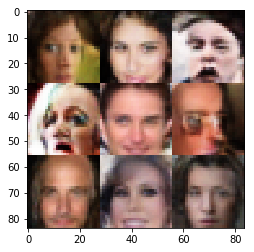

Epoch 8/10... Discriminator Loss: 1.0561... Generator Loss: 1.4230
Epoch 8/10... Discriminator Loss: 1.1507... Generator Loss: 0.9417
Epoch 8/10... Discriminator Loss: 1.0643... Generator Loss: 0.8923
Epoch 8/10... Discriminator Loss: 1.1029... Generator Loss: 0.6760
Epoch 8/10... Discriminator Loss: 0.9566... Generator Loss: 0.7805
Epoch 8/10... Discriminator Loss: 1.1008... Generator Loss: 1.1436
Epoch 8/10... Discriminator Loss: 0.9696... Generator Loss: 0.9387


KeyboardInterrupt: 

In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.